# Spike sorting pipeline using spike morphology features

## Introduction
This notebook demonstrates the process of computing feature sets on electrophysiological signals that contain neural activity in peripheral nerve fibers. We use a sample file recorded and pre-processed with Dapsys (www.dapsys.net) to illustrate the workflow. The steps include reading the raw data file, creating a pandas DataFrame, pre-processing the data, and computing feature sets on the DataFrame. These feature sets can then be used as input for clustering and classification methods.

## Table of Contents
1. [Introduction](#Introduction)
2. [Imports](#Imports)
3. [Data Loading](#Data-Loading)
4. [Pre-processing](#Pre-processing)
5. [Templates and Filtering](#Templates-and-Filtering)
6. [Feature sets computation](#Feature-sets-computation)
    1. [Features from SS-SPDF method](#Features-from-SS-SPDF-method)
    2. [Amplitude and width ("basic features")](#Amplitude-and-width)
7. [Visualization](#Visualization)
8. [Sorting](#Sorting)
    1. [Pre-processing for evaluation](#Pre-processing-for-evaluation)
    2. [Clustering](#Clustering)
    3. [Classification](#Classification)
9. [Results](#Results)

## Imports

In [1]:
import pandas as pd
import numpy as np
import quantities as pq
import neo
from neo.io import NixIO
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import typing
import csv
from numba import njit
from numpy import float32, float64
import pydapsys
from pydapsys.file import File
from pydapsys.page import TextPage, WaveformPage
from pydapsys.toc.entry import StreamType, Stream, Folder
from pydapsys.neo_convert.ni_pulse_stim import NIPulseStimulatorToNeo
import typing
import sys
from scipy.signal import savgol_filter, resample
from scipy.interpolate import splev, splrep
from sklearn.metrics.pairwise import euclidean_distances
from math import e, log, sqrt
from scipy.stats import moment
from statistics import stdev
from collections.abc import Iterable
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn import svm
from collections import Counter
from sklearn import metrics
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

## Data Loading
In this section, we will load the dataset using the package [PyDapsys](https://pypi.org/project/pydapsys/) and create the Pandas DataFrames and Series for the signal, spiketrains, and stimulation times. <br>


<span style="color: red; font-weight: bold;">Before running the notebook, please note the following:</span>
1. <b>Adjust Path Variable:</b>
    ```bash
    MY_DAPSYS_FILE = 'path/to/your/data.dps'
    ```
    
2. <b>Handling Potential Error:</b>

    A ```
    ToCNoSuchChildError: No child named "NI Puls Stimulator" in this item 
    ```error can occure in the method ```get_continuous_recording```, since sometimes the path variable is not 
    ```NI Puls Stimulator/Continuous Recording```, but ```NI Pulse Stimulator/Continuous Recording```. The word "Puls" needs to be adjusted depending on the root name with "e" or without "e". 
    
    
3. <b>Selecting only a part of the recording:</b>

    When only a subset of action potentials should be analyzed (e.g., depending on the stimulation protocol), the DataFrame needs to be sliced. For example, if only the action potentials (APs) between 500 and 1000 seconds should be included, replace the DataFrame ```spikes``` with the following code:
    ```bash
    spikes = spikes[(spikes['spike_ts'] >= 500) & (spikes['spike_ts'] <= 1000)]
    ````

In [4]:
# TODO needs to be adjusted
# file path and dataset name
MY_DAPSYS_FILE = r"C:\Users\alina\Documents\UKA\Paper\Spike shape paper\Code update\Test data\testset_1.dps"
dataset_name = "test"
    
# methods to get continuous recording and return as Pandas series
@njit
def _kernel_offset_assign(target: np.array, calc_add, calc_mul, pos_offset, n):
    for i in range(n):
        target[pos_offset + i] = calc_add + i * calc_mul

def get_continuous_recording(file: File) -> pd.Series:
    # it could be needed to adjust path variable and write NI Pulse Stimulator
    # or NI Puls Stimulator
    path = r"NI Puls Stimulator/Continuous Recording"
    total_datapoint_count = sum(len(wp.values) for wp in file.get_data(path, stype=StreamType.Waveform))
    values = np.empty(total_datapoint_count, dtype=float32)
    timestamps = np.empty(total_datapoint_count, dtype=float64)
    current_pos = 0
    for wp in file.get_data(path, stype=StreamType.Waveform):
        wp: WaveformPage
        n = len(wp.values)
        values[current_pos:current_pos + n] = wp.values
        if wp.is_irregular:
            timestamps[current_pos:current_pos + n] = wp.timestamps
        else:
            _kernel_offset_assign(timestamps, wp.timestamps[0], wp.interval, current_pos, n)
        current_pos += n
    print("finished loading continuous recording")
    return pd.Series(data=values, index=pd.Index(data=timestamps, copy=False, name="raw_ts"),
                     name="raw_amplitude", copy=False)

# helper to rename index of dataframe or series 
def rename_index(pd_obj, new_name: pq.second):
    return pd_obj.reindex(pd_obj.index.rename(new_name))

# read in spike trains
def spike_train_to_pd_series(train: neo.SpikeTrain):
    return pd.Series( train.name,index=train.as_array().flatten(),name='track')\
            .pipe(rename_index, 'spike_ts')

# read in comments
def comments_to_pd_series(event: neo.Event):       
    return pd.Series( event.labels,index=event,name='text')\
            .pipe(rename_index, 'comment_ts')

# read in dapsys file and convert to Neo block
with open(MY_DAPSYS_FILE, 'rb') as file:
    file = File.from_binary(file)
    neo_block = NIPulseStimulatorToNeo(file, grouping_tolerance=1e-9).to_neo()

# create Series with raw_data
raw_data = get_continuous_recording(file)


# create df with stimulation times
stimulations = pd.Series(neo_block.segments[0].events[0].as_array().flatten(), name='stimulation_ts')\
                .pipe(rename_index, 'stimulation_idx')

# create df with spike times
spikes = pd.concat(spike_train_to_pd_series(train) for train in neo_block.segments[0].spiketrains)\
    .sort_index()\
    .to_frame()\
    .reset_index()\
    .pipe(rename_index, 'spike_idx')

# only analyze part of recording, here, for example between second 200 and 505
spikes = spikes[(spikes['spike_ts'] >= 200) & (spikes['spike_ts'] <= 505)]\
            .reset_index(drop=True)\
            .pipe(rename_index, 'spike_idx')


track_names = sorted(spikes['track'].unique())

# create Series with comments 
comments = comments_to_pd_series(neo_block.segments[0].events[1])
display(comments)

finished loading continuous recording


comment_ts
898.572208 s                                    3 g on
912.819322 s                                   3 g off
948.710308 s                                  4,6 g on
963.862987 s                                 4,6 g off
986.869903 s                                    3 g on
1015.626191 s                                  3 g off
1031.575347 s                                 1,2 g on
1064.794317 s                                1,2 g off
1080.861319 s                                0,54 g on
1104.778504 s                               0,54 g off
1116.964305 s                                 brush on
1128.089068 s                                brush off
1140.789098 s                                 brush on
1156.935088 s                                brush off
1193.921353 s                      mapping 9,5g spot A
1203.715968 s                  mapping 9,5g spot A off
1210.097524 s                   mapping 9,5g spot A on
1225.555300 s                          mapping 9,5g on

## Pre-processing
In this section, we will extract the spikes/action potentials from the raw signal using a window function. The indices are shifted so that the minimum of the spike (negative peak) is in the middle of the window. The window size depends on the sampling frequency. The spike should be within a 3 ms window, and Dapsys samples the data at a sampling frequency (SF) of 10,000 Hz. Therefore, we use a window with 30 data points.

In [5]:
# Mapping of time stamps to index and alignment of spikes 
def ts_to_idx_col(column, data:pd.Series):
    # index array holds the index of the spike and it should be the minimum 
    index_array = data.index.get_indexer(column, method='nearest')
    for i in range(len(index_array)):
        bounds = [index_array[i]-15, index_array[i]+15]  
        bounds_arange = np.arange(index_array[i]-15, index_array[i]+15)  
        min_index = bounds_arange[data.iloc[bounds[0] :bounds[1]].argmin()] 
        # check if index array value aligns with min_index, if not replace it by min index to
        # ensure alignment of all spikes
        if not (index_array[i] ==  (min_index)):
            index_array[i] = min_index 
    return index_array

# helper function to get bounds of data slice
def bounds(row, idx_val:typing.Union[str,int]=0, lower:int=0,upper:int=0):
    v=row[idx_val]
    return [v+lower, v+upper]

# compute gradient
def pandas_gradient(series):
    #return series.diff()
    return pd.Series(np.gradient(series.values), index= series.index)

# compute zerocrossing
def zerocrossings(series: pd.Series) -> pd.Series:
    signs = np.sign(series.values)
    return pd.Series((signs[i] != signs[i - 1] for i in range(1,len(series))),index=series.index[1:])

# compute first and second derivative of signal
def calculate_fd_sd(row, data:pd.Series, idx_window_start_iloc=0, idx_window_end_iloc=1):
    start = row[idx_window_start_iloc]
    end = row[idx_window_end_iloc]
    raw = data.iloc[start-2:end]
    # upsample to make fd computation better
    raw_upsampled = pd.Series(resample(raw, 60))
    fd = pandas_gradient(raw_upsampled)
    fd_zero = zerocrossings(fd)
    sd = pandas_gradient(fd)
    return [fd.iloc[1:].to_list(), sd.iloc[2:].to_list(), fd_zero.iloc[1:].to_list(), raw.values]

# create df with 
ap_window_iloc = spikes[["spike_ts"]]\
    .progress_apply(ts_to_idx_col, args=(raw_data,), axis=0)\
    .progress_apply(bounds, axis=1, result_type='expand',lower=-15, upper=15 )\
    .rename(columns={0:'start_iloc', 1:'end_iloc'})

# create df with derivatives 
ap_derivatives = ap_window_iloc[['start_iloc','end_iloc']]\
        .progress_apply(calculate_fd_sd, args=(raw_data,), axis=1, result_type='expand')\
        .rename(columns={0:'fd', 1:'sd', 2:'fd_crossings', 3: "raw"})

# merge df with indices and with spike times and track
ap_track_window = ap_window_iloc.merge(spikes, on='spike_idx')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

## Templates and Filtering
Additionally, we compute a template for each track by averaging all spikes. This template is then used to filter the spikes, dropping any spikes that fall outside a specified range based on the template.

In [6]:
# find threshold bounds of templates, which are created by taking the mean of spikes per track
# current filter computes the range [min(template) - (min(template) * 0.3, min(template) + (min(template) * 0.3]
# so it checked if the negative peak is inside this bound 
def find_threshold_bounds(ap_track_window):
    ap_templates = pd.DataFrame()
    thresholds_template = {}
    for track in ap_track_window['track'].unique():
        ap_track_window_sorted = ap_track_window[(ap_track_window['track'] == track)]
        ap_raw = ap_track_window_sorted[['start_iloc','end_iloc']]\
            .progress_apply(extract_raw_values, args=(raw_data,), axis=1, result_type='expand')
        template = ap_raw.mean()
        print(f"template min for {track}", min(template))
        thresholds_template[track] = [round(min(template) - (min(template) * 0.3),2)]
        thresholds_template[track].append(round(min(template) + (min(template) * 0.3),2))
        print(thresholds_template)
        data = pd.DataFrame({"track":track, "template" :[template.to_list()]})
        ap_templates = pd.concat([ap_templates,data])

    return ap_templates.reset_index(drop=True), thresholds_template

# extract raw values
def extract_raw_values(row, data:pd.Series, idx_window_start_iloc=0, idx_window_end_iloc=1):
    start = row[idx_window_start_iloc]
    end = row[idx_window_end_iloc]
    raw = data.iloc[start:end]
    return raw.to_list()

# helper function to filter by threshold
def filter_by_threshold(row, thresholds):
    raw = row.raw
    min_raw = min(raw)
    return round(min_raw,2) <= thresholds[row.track][0] and round(min_raw,2) >= thresholds[row.track][1]

ap_templates, thresholds_template = find_threshold_bounds(ap_track_window)
display(ap_templates)
# add column, if spike shold be droped
ap_track_window["drop_min"] = ap_track_window\
        .join(ap_derivatives)\
        .progress_apply(filter_by_threshold, args=(thresholds_template,), axis=1, result_type='expand')\

# create list of indices with spikes that should be dropped
drop_index_below_thresholds = ap_track_window.index[ap_track_window['drop_min'] == False].tolist()


  0%|          | 0/71 [00:00<?, ?it/s]

template min for Track3 -6.267458385145161
{'Track3': [-4.39, -8.15]}


  0%|          | 0/71 [00:00<?, ?it/s]

template min for Track2 -3.267781588393198
{'Track3': [-4.39, -8.15], 'Track2': [-2.29, -4.25]}


,track,template
0,Track3,"[-0.018520130493848676, -0.031053916354414443,..."
1,Track2,"[0.1335785466010197, 0.161082012159094, 0.1582..."


  0%|          | 0/142 [00:00<?, ?it/s]

## Feature sets computation
For each action potential, we compute feature sets that can be used as input for classification and clustering.
| Identifier | Feature set |
| --- | --- | 
| F1 | Amplitude and width (“basic features”) | 
| F2 | PCA of SS-SPDF features (2-comp) | 
| F3 | PCA of SS-SPDF features (3-comp) | 
| F4 | Raw SS-SPDF features | 
| F5 | PCA of raw waveform features (2-comp)| 
| F6 | PCA of raw waveform features (3-comp) | 
| F7 |Raw waveform features | 

### Features from SS-SPDF method 

Here, we implemented the phase-, shape-, and distribution-based features as described by [Caro-Martín et al.](https://pubmed.ncbi.nlm.nih.gov/30542106/) However, we had to modify two feature definitions. For feature 4, the reference waveform was not defined, so we excluded feature 4 from the final feature vector. Feature 8 had a mismatch between the formula and the feature description, as well as some missing variable definitions. Therefore, we redefined feature 8.

In [7]:
# compute components 
def __lasttrue(series:pd.Series) -> float:
    last_true_at = None
    for idx,v in series.items():
        if v:
            last_true_at = idx
    if last_true_at == None:
        last_true_at = 0
    return last_true_at


# updated function to find principal points for SS-SPDF method, can fail due to spike shape
# and the first derivative
def __calc_components(name, fd, crossings, raw_index, raw):
    p2 = fd.iloc[20:31].idxmin()
    p1,p3,p4,p5,p6 = None,None,None,None,None
    try:
        p1 = __lasttrue(crossings.iloc[:fd.index.get_loc(p2)])
        try:
            p3 = crossings.iloc[fd.index.get_loc(p2)+1:].idxmax()
            try:
                p5 = crossings.iloc[fd.index.get_loc(p3)+1:].idxmax()
                try:
                    p4 = fd.iloc[fd.index.get_loc(p3)+1:fd.index.get_loc(p5)].idxmax()
                except:
                    print("error in p4")
                    pass
                try:
                    p6 = fd.iloc[fd.index.get_loc(p5)+1:fd.index.get_loc(p5)+10].idxmin()
                except:
                    print("error in p6")
                    pass
            except:
                print("error in p5")
                pass
        except:
            print("error in p3")
            pass
    except Exception as e:
        print("error in p1")
        pass
    return [p1,p2,p3,p4,p5,p6]


# method to start the principal point computation
def calculate_components(row, data:pd.Series, idx_start_iloc='start_iloc', idx_end_iloc='end_iloc', idx_fd='fd', idx_fd_crossings='fd_crossings'):
    ap_start = row[idx_start_iloc]
    ap_end = row[idx_end_iloc]
    raw = data.iloc[ap_start:ap_end]
    fd = pd.Series(row[idx_fd])
    crossings = pd.Series(row[idx_fd_crossings])#, index=raw.index)
    return __calc_components(row.name,fd,crossings, raw.index, raw) 

# helper to compute mean change between two values
def __mean_change_between(series:pd.Series, x:float, y:float) -> float:
    return (series.at[x] - series.at[y]) / (x-y)

# helper to compute root mean square of series 
def __calculate_rms(series:pd.Series) -> float:
    summed_series = series.map(lambda x: x * x).sum()
    div = series.index[-1] - series.index[0]
    return sqrt(summed_series / div)

# helper to compute slope ratio of AP
def __slope_ratio(series:pd.Series, a:float,b:float,c:float) -> float:
    part_a = (series.at[b] - series.at[a]) / (b-a)
    part_b = (series.at[c] - series.at[b]) / (c-b)
    return part_a/part_b

# helper to compute inter quantile range
def __iqr(series:pd.Series) -> float:
    Q3 = np.quantile(series, 0.75)
    Q1 = np.quantile(series, 0.25)
    return Q3-Q1

# helper function to compute moment
def __sampling_moment_dev(vals: pd.Series, n: int) -> float:
    return moment(vals, n) / pow(stdev(vals), n)

# feature definitions
def __feature_calc(fd:pd.Series, sd:pd.Series, p1:float,p2:float,p3:float,p4:float,p5:float,p6:float):
    f = [None]*24

    p1_loc,p5_loc= fd.index.get_indexer([p1,p5], method='nearest')
    # shape based features
    #print(p5, p1)
    f[0] = p5-p1
    f[1] = fd.at[p4]-fd.at[p2]
    f[2] = fd.at[p6]-fd.at[p2]
    # f[3] skip F4 as we have redefined it and will calculate it at another point
    f[4] = log(abs(__mean_change_between(fd, p4,p2)),e)
    f[5] = __mean_change_between(fd,p6,p4)
    try:
        f[6] = log(abs(__mean_change_between(fd,p6,p2)),e)
    except:
        print("F6 error")
        pass
    f[7] = __calculate_rms(fd.iloc[:p1_loc+1])
    f[8] = __slope_ratio(fd,p1,p2,p3)
    f[9] = __slope_ratio(fd,p3,p4,p5)
    f[10] = fd.at[p2]/fd.at[p4]

    # phase based features
    for i,p in enumerate((p1,p3,p4,p5,p6)):
        f[11+i] = fd.at[p]
    for i,p in enumerate((p1,p3,p5)):
        f[16+i] = sd.at[p]

    # distribution based features
    ## not sure it should not be p6
    for i,ser in enumerate((fd,sd)):
        f[19+i] = __iqr(ser.loc[p1:p5])
    f[21] = __sampling_moment_dev(fd.loc[p1:p5],4)
    f[22] = __sampling_moment_dev(fd.loc[p1:p5],3)
    f[23] = __sampling_moment_dev(sd.loc[p1:p5],3)
    return f

# method to start feature computation
def calculate_features(row, data, idx_start_iloc='start_iloc', idx_end_iloc='end_iloc', idx_p1='P1', idx_p2='P2', idx_p3='P3', idx_p4='P4', idx_p5='P5', idx_p6='P6', idx_fd="fd", idx_sd='sd'):
    ap_start = row[idx_start_iloc]
    ap_end = row[idx_end_iloc]
    p1 = row[idx_p1]
    p2 = row[idx_p2]
    p3 = row[idx_p3]
    p4 = row[idx_p4]
    p5 = row[idx_p5]
    p6 = row[idx_p6]
    raw = data.iloc[ap_start:ap_end]
    fd = pd.Series(row[idx_fd])#, index=raw.index)
    sd = pd.Series(row[idx_sd])#, index=raw.index)
    return __feature_calc(fd,sd,p1,p2,p3,p4,p5,p6)

feature_descriptors = {f'F{i}':desc for i,desc in (
    (1,'waveform duration'),
    (2,'FD peak-to-valley amplitude'),
    (3,'FD valley-to-valley amplitude'),
    (4,''),
    (5,'Natural logarithm of the FDs positive deflection'),
    (6,'FD negative deflection'),
    (7,'Natural logarithm of the FDs slope among valleys'),
    (8,'RMS of the FDs pre-AP amplitudes'),
    (9,'FD negative slope ratio'),
    (10,'FD positive slope ratio'),
    (11,'FD peak-to-valley ratio'),
    (12,'FD amplitude at P1'),
    (13,'FD amplitude at P3'),
    (14,'FD amplitude at P4'),
    (15,'FD amplitude at P5'),
    (16,'FD amplitude at P6'),
    (17,'SD amplitude at P1'),
    (18,'SD amplitude at P3'),
    (19,'SD amplitude at P5'),
    (20,'FD IQR'),
    (21,'SD IQR'),
    (22,'FD Kurtosis coefficient'),
    (23,'FD Fisher asymmetry'),
    (24,'SD Fisher asymmetry')
)}


# create df with components
components = ap_derivatives\
                    .join(ap_window_iloc)\
                    .progress_apply(calculate_components, args=(raw_data,), axis=1, result_type="expand")\
                    .rename(columns={i:f"P{i+1}" for i in range(6)})
print("before filtering", len(components))
# drop spikes that are out of bounds from template
components = components.drop(drop_index_below_thresholds)
print("after filtering", len(components))
components.dropna(inplace=True)

# create df with SS-SPDF features
features = components\
                    .join(ap_derivatives)\
                    .join(ap_window_iloc)\
                    .progress_apply(calculate_features, args=(raw_data,), axis=1, result_type="expand")\
                    .rename(columns={i:f"F{i+1}" for i in range(24)})\
                    .drop(columns=["F4"])

display(features)

  0%|          | 0/142 [00:00<?, ?it/s]

before filtering 142
after filtering 120


  0%|          | 0/120 [00:00<?, ?it/s]

,F1,F2,F3,F5,F6,F7,F8,F9,F10,F11,...,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24
spike_idx,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.301777,1.226879,-1.203434,-0.138327,-3.053623,0.554617,-1.000549,-1.091324,-1.727335,...,0.121113,-0.864274,-0.643068,0.346770,-0.122383,1.697575,0.503136,1.898867,-0.616501,-0.151895
1,24.0,1.387189,0.442702,-2.445309,-0.118061,-3.992913,0.266249,-1.515394,-0.365285,-1.511604,...,0.053774,-0.392175,-0.323853,0.141816,-0.097552,0.698279,0.196775,1.809551,-0.510580,-0.567260
2,21.0,2.636219,0.739450,-1.227879,-0.145905,-3.392891,0.427236,-1.513490,-2.256346,-1.004687,...,0.117241,-0.581741,-0.414222,0.533306,-0.205106,1.310954,0.428425,1.719727,-0.261858,0.457452
4,22.0,2.506223,0.698860,-1.160665,-0.106315,-3.577180,0.478833,-0.958951,-2.594011,-1.327821,...,0.032548,-0.730724,-0.406074,0.482007,-0.129227,1.479443,0.293287,1.684942,-0.403117,0.474076
5,24.0,1.919232,0.526243,-1.650660,-0.198998,-3.475206,0.470451,-0.488244,-0.804347,-0.985244,...,0.205777,-0.426241,-0.352352,0.208088,-0.291142,1.154371,0.295124,1.431253,0.078035,0.048695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,22.0,1.765889,0.511400,-1.733931,-0.083633,-3.889480,0.266070,-0.878221,-1.340562,-0.755224,...,0.091462,-0.248413,-0.167394,0.143899,-0.148702,0.836858,0.294218,1.768746,0.182310,0.379975
136,20.0,3.290694,1.106036,-1.006126,-0.145644,-3.077272,0.606067,-1.187874,-1.664066,-1.275031,...,0.166591,-0.738219,-0.572150,0.577654,-0.133536,1.839353,0.498927,1.567122,-0.344550,0.114300
138,20.0,3.288618,1.202270,-0.755443,-0.173862,-2.760227,0.497967,-0.638511,-3.733849,-1.356936,...,0.571328,-0.691054,-0.387921,0.566913,-0.538571,2.111740,0.665453,1.514710,-0.343126,0.289430


### Amplitude and width
Here, we compute the amplitude and width of spikes, referring to them as "basic features" since they are commonly used to quantify spike morphology.

In [8]:
# compute simple features
features_basic = {0:"Amplitude", 1:"Width", 2:"NegAmplitude", 2:"NegWidth"}
def calculate_features_basic(row, data, idx_start_iloc='start_iloc', idx_end_iloc='end_iloc', idx_p1='P1', idx_p2='P2', idx_p3='P3', idx_p4='P4', idx_p5='P5', idx_p6='P6', idx_fd="fd", idx_sd='sd'):
    ap_start = row[idx_start_iloc]
    ap_end = row[idx_end_iloc]
    raw = data.iloc[ap_start:ap_end]
    raw2 = pd.Series(resample(raw, 60))  
    amp = raw2.iloc[20:40].idxmin() 
    h = raw2[amp]
    half_height = round(raw2[amp] /2,6)
    first_half = raw2.iloc[amp-15:amp]
    second_half = raw2.iloc[amp:amp+15]
    # np.interp for monotonically increasing sample points
    first = np.interp(-half_height, (-1)*first_half.values, np.array(first_half.index))
    second = np.interp(half_height,second_half.values,np.array(second_half.index))
    return h, abs(first-second)

# create df with basic features 
features_basic = components\
                        .join(ap_derivatives)\
                        .join(ap_window_iloc)\
                        .progress_apply(calculate_features_basic, args=(raw_data,), axis=1, result_type="expand")\
                        .rename(columns={i:f"{features_basic[i]}" for i in features_basic})

  0%|          | 0/120 [00:00<?, ?it/s]

## Visualization

Here, we plot the templates, raw waveforms and boxplots of the feature value distribution.

,track,template
0,Track3,"[-0.018520130493848676, -0.031053916354414443,..."
1,Track2,"[0.1335785466010197, 0.161082012159094, 0.1582..."


  0%|          | 0/2 [00:00<?, ?it/s]

0    None
1    None
dtype: object

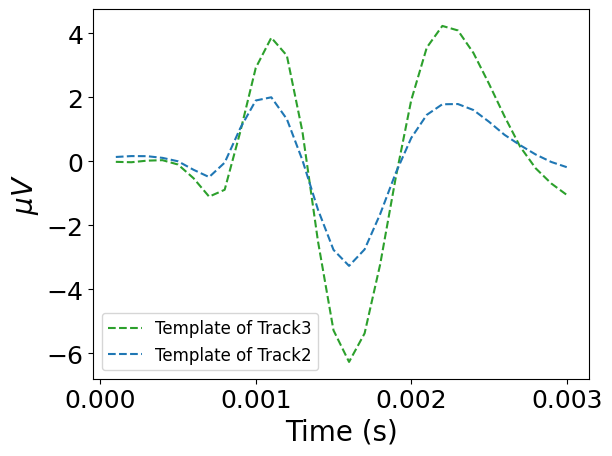

In [9]:
# plot tempaltes of tracks
def plot_template(row, ax1, track_colors):
    template = pd.Series(row["template"], index=[round(x, 4) for x in np.arange(0, len(row["template"]) * 0.0001, 0.0001)])
    ax1.plot([round(x, 4) for x in np.arange(0.0001, (len(template) * 0.0001 + 0.0001), 0.0001)], template.values,
         c=track_colors[row.track], alpha=1, linestyle="dashed",
         label="Template of " + row.track)
    ax1.legend(fontsize=12)
    ax1.set_xlabel("Time (s)", fontsize=20)
    ax1.set_ylabel(u'${\mu}V$', fontsize=20)
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18)
    
# color list to extract colors 
colors = ["tab:blue", "tab:green","tab:orange", "tab:red","tab:cyan", "tab:brown", "tab:pink", "tab:olive"]
# if error, new colors needs to be added
assert len(track_names) < len(colors)
track_colors = {track_names[i]:colors[i] for i in range(len(track_names))}

fig = plt.figure()
plt.rcParams["font.size"] = 10
ax1 = fig.add_subplot(111)
display(ap_templates)
ap_templates.progress_apply(plot_template, args=(ax1,track_colors), axis = 1 , result_type="expand")

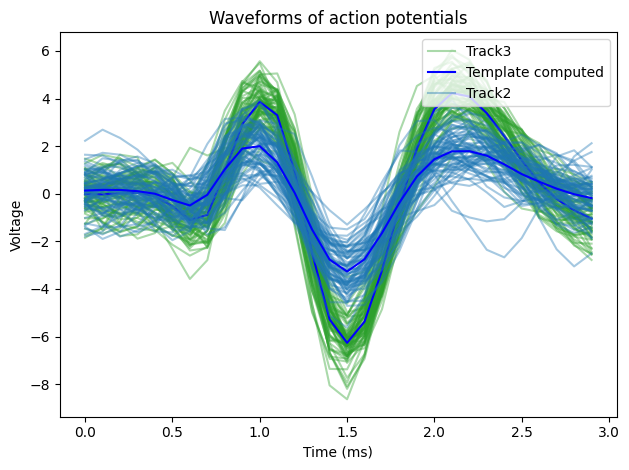

In [10]:
# plot raw waveform
templates = None

def ax_plot(ax, *ax_args, **ax_kv_args):
    return ax.plot(*ax_args, **ax_kv_args)

def ax_scatr(ax, *ax_args, **ax_kv_args):
    return ax.scatter(*ax_args, **ax_kv_args)

def plot_ap_shape(df: pd.DataFrame, raw_data:pd.DataFrame, style="scatter",color_dict=track_colors,type='single', templates=None, template2=None, accent_color="green"):
    if accent_color is None:
        accent_color = color_dict['marker']
    if style == 'plot':
        plot_func = ax_plot
    elif style == 'scatter':
        plot_func = ax_scatr
    else:
        raise Exception(f"Unknown style {style}")
    if type == 'single':
        fig,ax = plt.subplots(1,1)
        waveforms = []
        tracks = []
        legend_labels = []
        for track in df['track'].unique():
            label_args = {'label':f"{track}"}
            for row,r in df[(df['track'] == track)][['start_iloc','end_iloc']].iterrows():
                ax.set_title(row)
                waveforms.append(raw_data.iloc[r[0]:r[1]].to_numpy())
                tracks.append(track) 
                plot_func(ax,np.arange(0, 3, 0.1),raw_data.iloc[r[0]:r[1]].to_numpy(), color=color_dict[track], alpha=0.4,**label_args) # , alpha=0.2
                label_args = {}
            if templates is not None:
                ax.plot(templates[track].to_numpy(), color=accent_color, label="template")
            if template2 is not None:
                template_track = template2.loc[template2['track'] == track]
                ax.plot(np.arange(0, 3, 0.1),template_track["template"].values[0], color="blue", label="Template computed" if "Template computed" not in legend_labels else "")
                legend_labels.append("Template computed")
            ax.set_title(f"{track} action potentials")
            ax.set_title("Waveforms of action potentials")
            ax.legend(loc = 1)
            ax.set_xlabel(f"Time (ms)")
            ax.set_ylabel(f"Voltage")
            fig.tight_layout()
            df_waveforms = pd.DataFrame(waveforms, columns =[ str(s) for s in list(np.arange(0, 3, 0.1))] ) 
        df_waveforms["track"] = tracks
    elif type == 'all':
        fig,ax = plt.subplots(1,1)
        label_args = {'label':"waveforms"}
        for _,r in df[['start_iloc','end_iloc']].iterrows():
            plot_func(ax,raw_data.iloc[r[0]:r[1]].to_numpy(), color=accent_color, **label_args)
            label_args = {}
        if templates is not None:
            for track, template in templates.items():
                ax.plot(template.to_numpy(), color=color_dict[track], label=f"{track} template")
        ax.set_title("all waveforms")
        ax.legend()
        ax.set_xlabel(f"datapoint")
        ax.set_ylabel(f"amplitude")
        fig.tight_layout()


ap_window_iloc\
    .join(spikes[['track']])\
    .pipe(plot_ap_shape, raw_data, templates=templates, template2=ap_templates, style="plot",)



C:\Users\alina\AppData\Local\Temp\ipykernel_26872\959213207.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\alina\AppData\Local\Temp\ipykernel_26872\959213207.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Series([], dtype: bool)


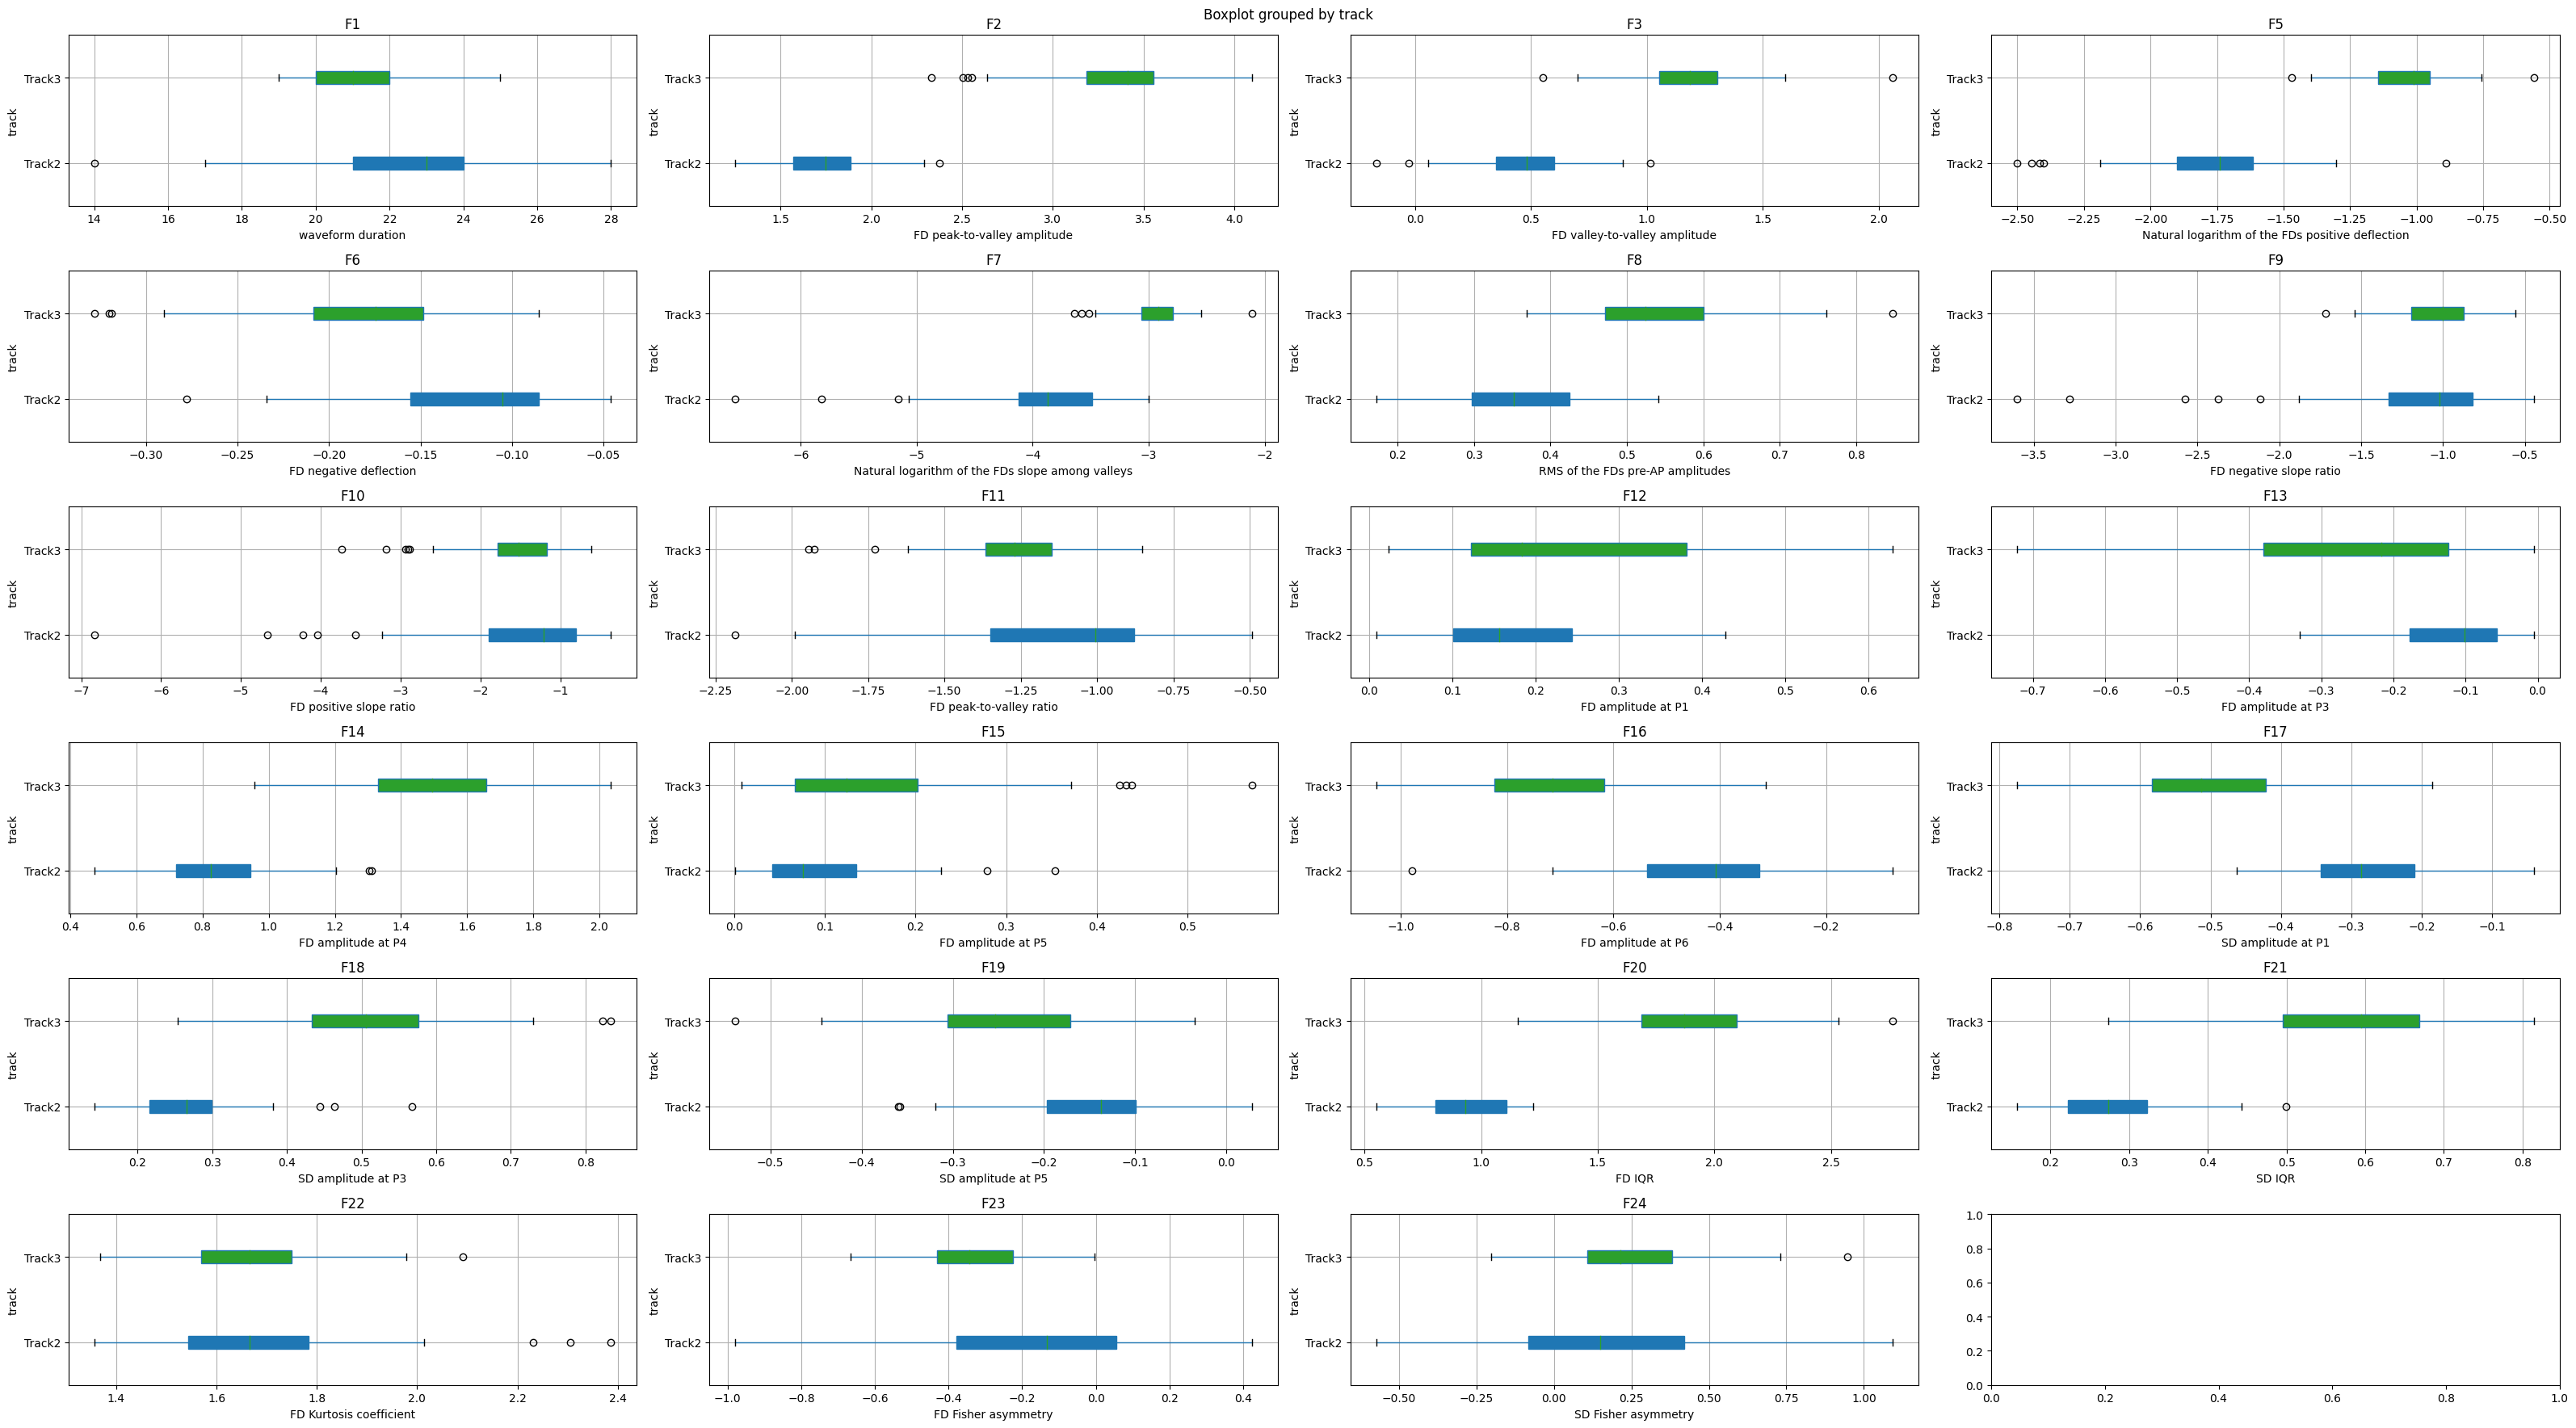

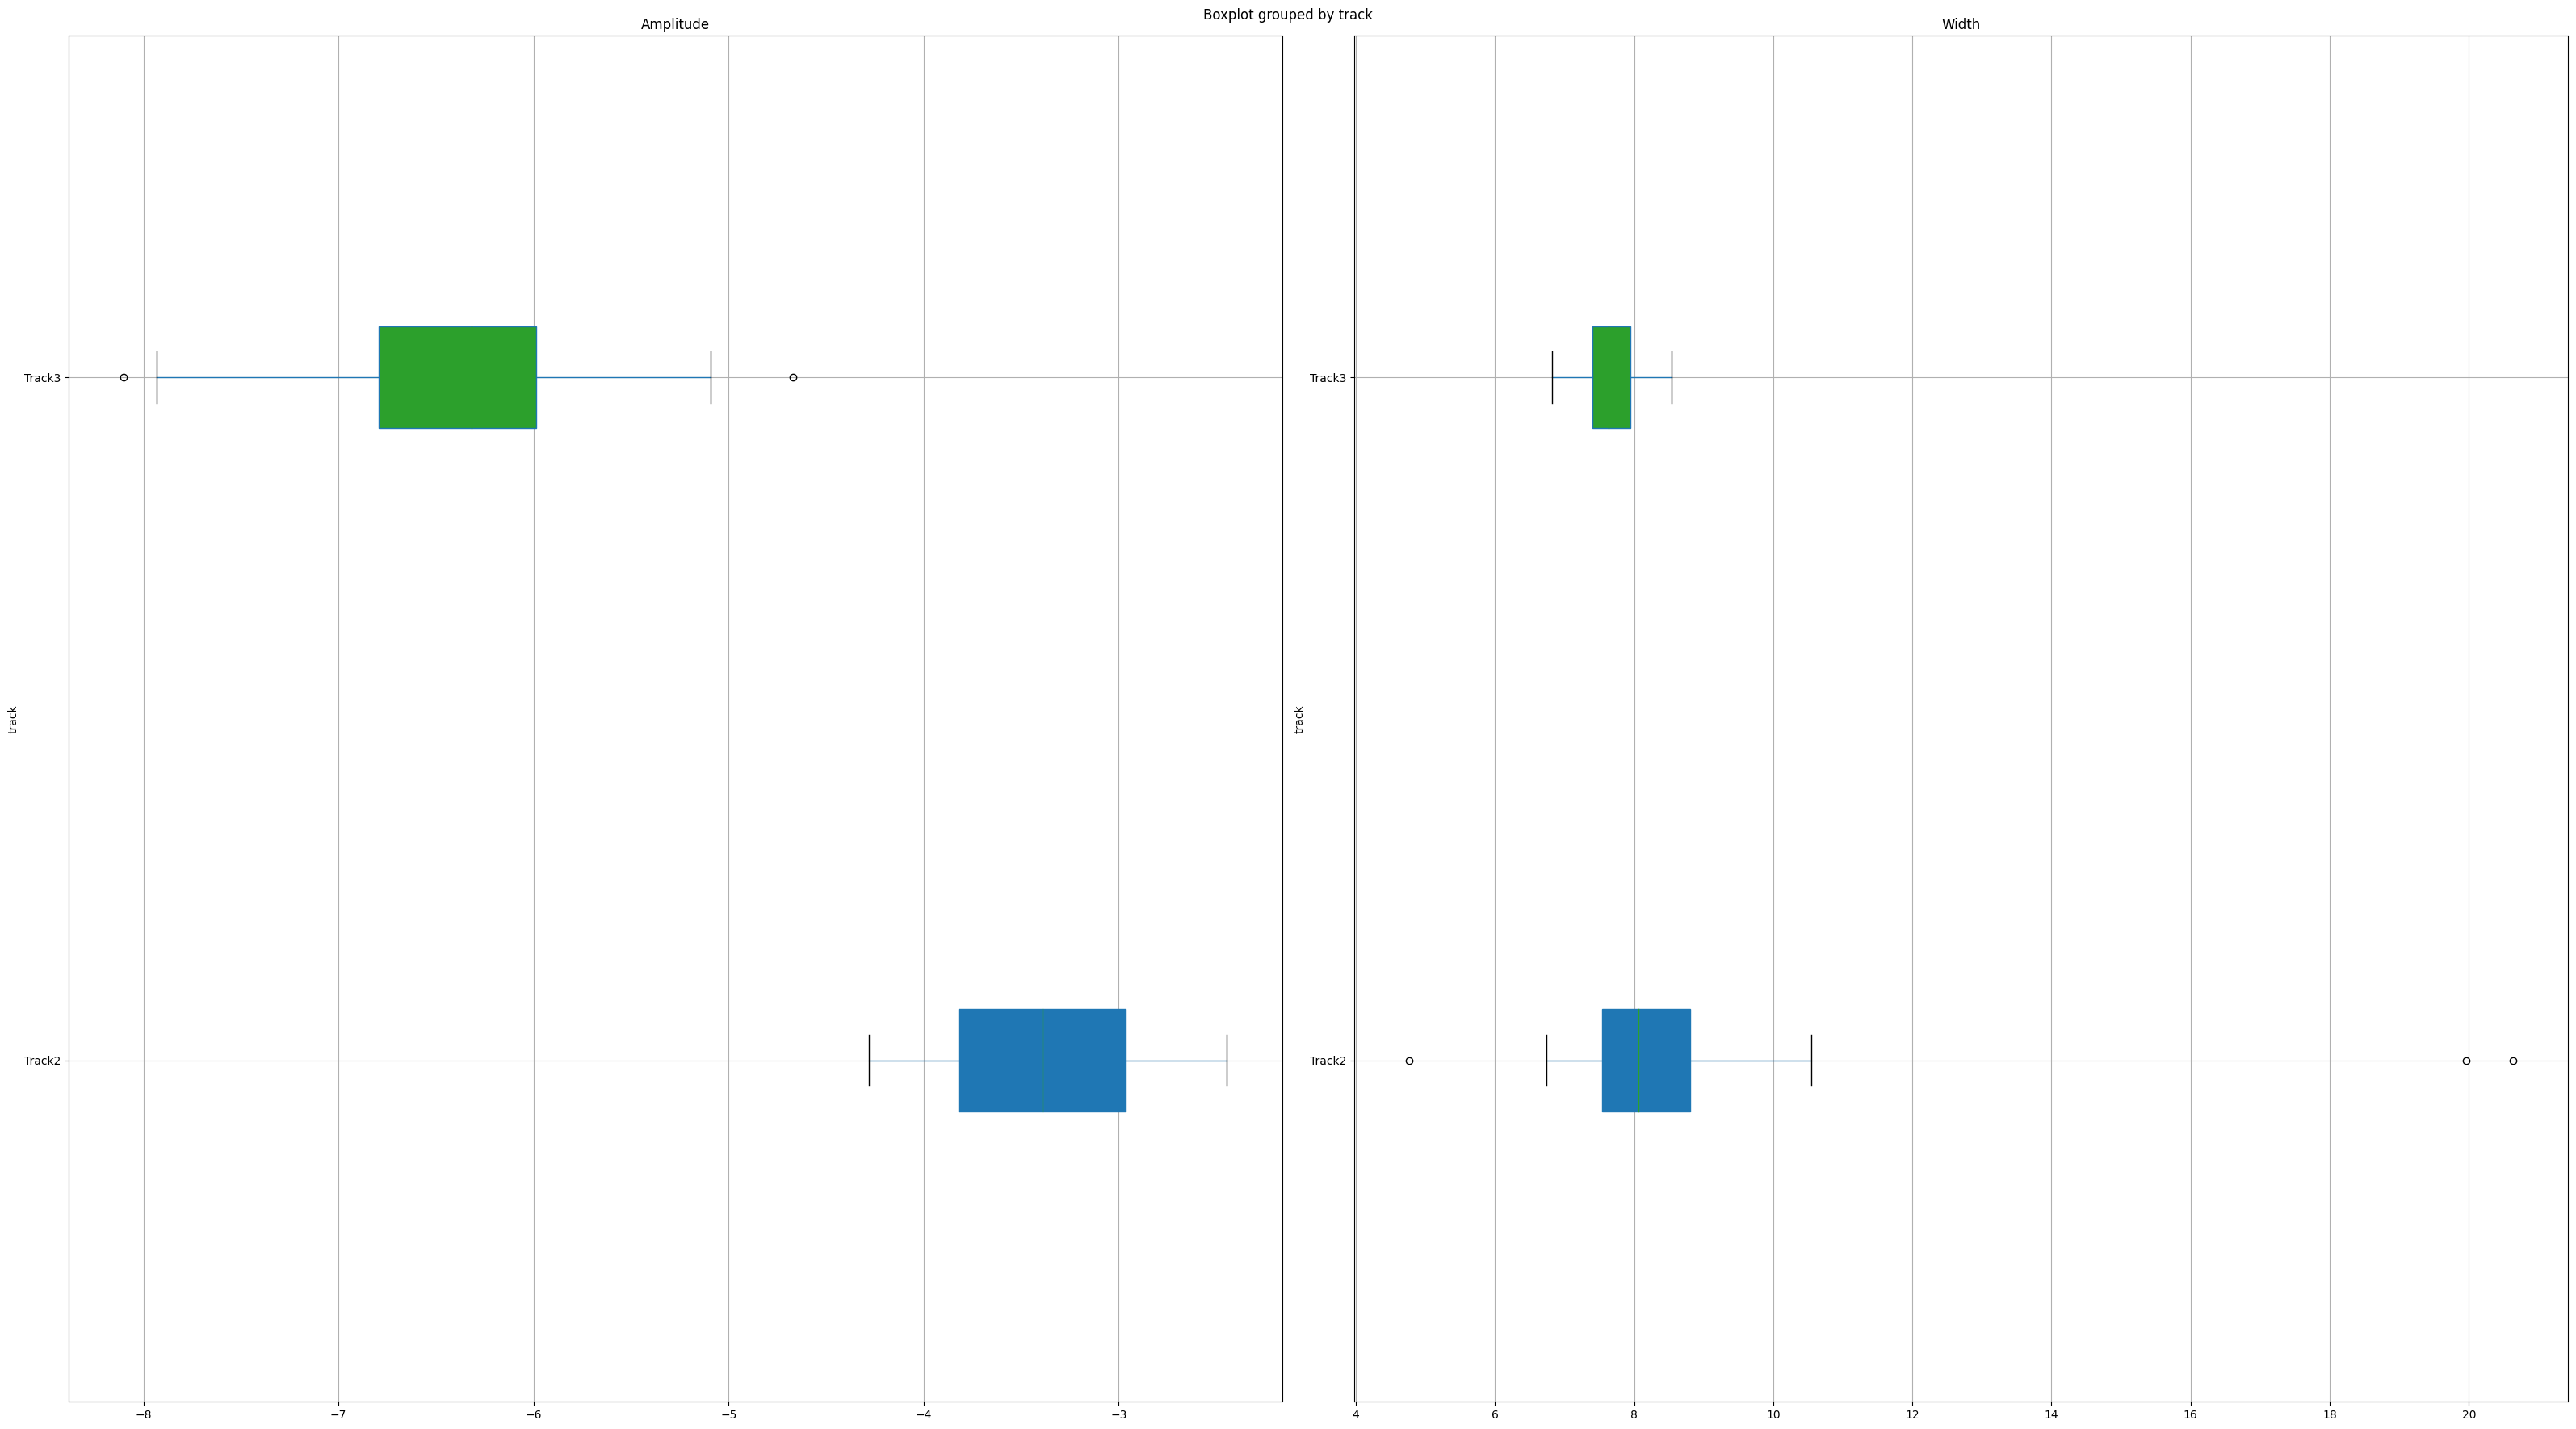

In [11]:
# plot feature values 
def iter_axes(axs):
    if not hasattr(axs, '__iter__'):
        yield axs
    else:
        for ax in axs:
            yield from iter_axes(ax)

def draw_featurebox(feature_df, ax, feature, by,colors,  vert=False):
    d = feature_df.boxplot(column=feature, ax=ax, by=by, vert=vert, patch_artist=True, return_type='dict')
    sorted_tracks = sorted(list(set(feature_df["track"])))
    colors = (track_colors[track] for track in sorted(list(set(feature_df["track"]))) )
    boxprops= dict(linewidth=10.0, color='black')
    for p,color in zip(d[feature]['boxes'], colors):
        p.set_facecolor(color)

def feature_boxplots(feature_df: pd.DataFrame, colors, columns=4,rows=None,descriptors=feature_descriptors, figsize=(32,18), by='track'):
    feature_names = feature_df.drop(columns=['track']).columns.tolist()
    if rows is None:
        feature_count = len(feature_names)
        rows = feature_count//columns+(feature_count%columns!=0)
    if rows == 1:
        columns=len(feature_names)
    fig, axs = plt.subplots(rows,columns, figsize=figsize)
    for ax, feature_name in zip(iter_axes(axs), feature_names):
        draw_featurebox(feature_df, ax, feature_name,by,colors)
        ax.set_xlabel(f"{descriptors.get(feature_name,'')}")
    fig.tight_layout()
    fig.show()
    


# plot boxplots
features\
    .join(spikes[["track"]])\
    .pipe(feature_boxplots, track_colors)

print(features.isna().any()[lambda x: x])

features_basic\
    .join(spikes[["track"]])\
    .pipe(feature_boxplots,track_colors)


## Sorting
We propose two pipelines: one using clustering and the other using classification, utilizing the labels for the tracks to train a classifier. First, we specify how to evaluate the scores by considering method-appropriate metrics.

### Pre-processing for evaluation

In [12]:
# create dict with score funcs for clustering 
score_funcs_clustering = [
    ("V-measure", metrics.v_measure_score),
    ("Rand index", metrics.rand_score),
    ("ARI", metrics.adjusted_rand_score),
    ("MI", metrics.mutual_info_score),
    ("NMI", metrics.normalized_mutual_info_score),
    ("AMI", metrics.adjusted_mutual_info_score),
    ("Homogeneity", metrics.homogeneity_score),
    ("FMI", metrics.fowlkes_mallows_score),
    ("Completeness", metrics.completeness_score),
    ("Accuracy", metrics.accuracy_score)
]

# create dict with score funcs for classification 
score_funcs_classification = [
    ("Accuracy", metrics.accuracy_score),
    ("Precision", metrics.precision_score),
    ("Recall", metrics.recall_score),
    ("F1-score", metrics.f1_score)
]

def call_score_func(func, args):
    score = func(*args)
    return round(score, 4)

def call_average_func(func, args):
    score = func(*args, average="macro")
    return round(score, 4)

# create dict to collect the scores for clustering
clustering_scores_dict = {}
def compute_scores_clustering(true_label, predicted_label, feature_name):
    clustering_score = {}
    for func in score_funcs_clustering:
        clustering_score[func[0]] = call_score_func(func[1], [true_label, predicted_label])
    clustering_scores_dict[feature_name] = clustering_score
    

# create dict to collect the scores for classification
classification_score_dicts = {}
def compute_scores_classification(true_label, predicted_label, feature_name):
    classification_score = {}
    for func in score_funcs_classification:
        if func[0] == "Accuracy":
            classification_score[func[0]] = call_score_func(func[1], [true_label, predicted_label])
        # for other functions each class has its own score, average it 
        else:
            classification_score[func[0]] = call_average_func(func[1], [true_label, predicted_label])
    if not feature_name in classification_score_dicts:
        classification_score_dicts[feature_name] = [classification_score]
    else:
        classification_score_dicts[feature_name].append(classification_score)                                                          
    
# create dict to collect mean of all folds for each classification score
classification_score_mean_dicts = {}
def compute_mean_classificaton():
    for feature in classification_score_dicts:
        mean_dict = {}
        scores = classification_score_dicts[feature][0].keys()
        for score in scores:
            tmp = []
            for i in range(5):
                tmp.append(classification_score_dicts[feature][i][score])
            mean_dict[score] = round(np.mean(tmp),4)
        classification_score_mean_dicts[feature] = mean_dict


### Clustering
In addition to using the basic features and the features from the SS-SPDF method, we include the raw waveform (an array of 30 data points). We apply principal component analysis (PCA) with two and three components for dimensionality reduction on the features from the SS-SPDF method and the raw waveform as input features for clustering.

To ensure the results are reproducible, we set a random seed. We use k-means clustering, adjusting the number of clusters based on the number of fibers/tracks in a recording. The clusters are initialized using the k-means++ method.

F1 {'V-measure': 1.0, 'Rand index': 1.0, 'ARI': 1.0, 'MI': 0.6842, 'NMI': 1.0, 'AMI': 1.0, 'Homogeneity': 1.0, 'FMI': 1.0, 'Completeness': 1.0, 'Accuracy': 1.0}
F2 {'V-measure': 0.2204, 'Rand index': 0.6392, 'ARI': 0.2776, 'MI': 0.1442, 'NMI': 0.2204, 'AMI': 0.2153, 'Homogeneity': 0.2107, 'FMI': 0.6633, 'Completeness': 0.2309, 'Accuracy': 0.2333}
F3 {'V-measure': 0.2343, 'Rand index': 0.6483, 'ARI': 0.2959, 'MI': 0.154, 'NMI': 0.2343, 'AMI': 0.2293, 'Homogeneity': 0.2251, 'FMI': 0.6698, 'Completeness': 0.2442, 'Accuracy': 0.775}
F4 {'V-measure': 0.2343, 'Rand index': 0.6483, 'ARI': 0.2959, 'MI': 0.154, 'NMI': 0.2343, 'AMI': 0.2293, 'Homogeneity': 0.2251, 'FMI': 0.6698, 'Completeness': 0.2442, 'Accuracy': 0.775}
F5 {'V-measure': 0.9071, 'Rand index': 0.972, 'ARI': 0.9441, 'MI': 0.6286, 'NMI': 0.9071, 'AMI': 0.9066, 'Homogeneity': 0.9069, 'FMI': 0.9718, 'Completeness': 0.9074, 'Accuracy': 0.9859}
F6 {'V-measure': 0.854, 'Rand index': 0.9583, 'ARI': 0.9167, 'MI': 0.5919, 'NMI': 0.854, 'AM

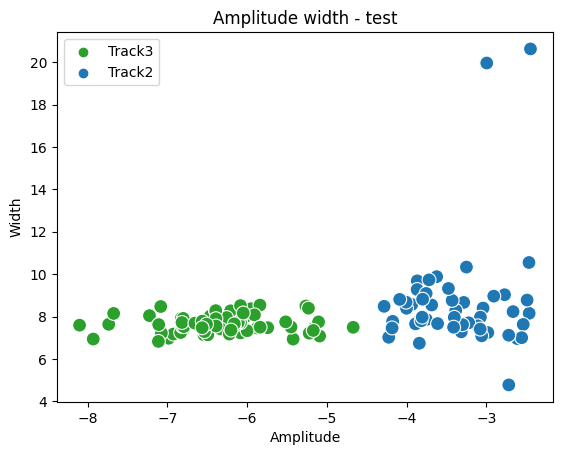

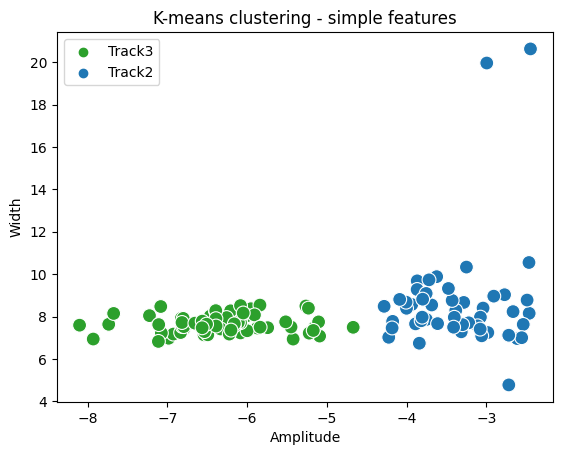

<Figure size 640x480 with 0 Axes>

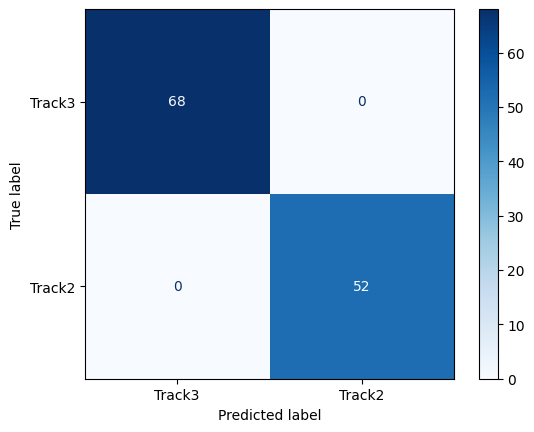

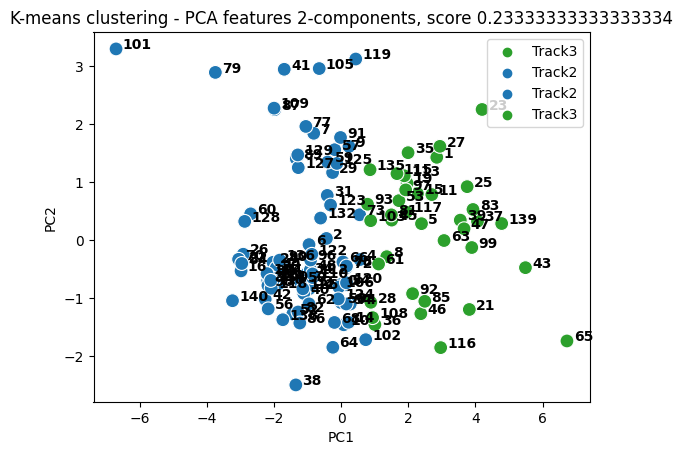

<Figure size 640x480 with 0 Axes>

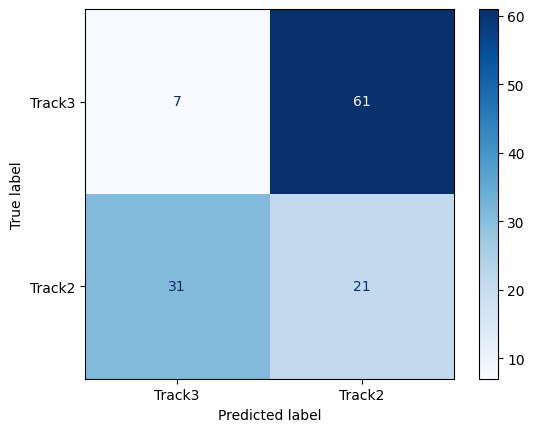

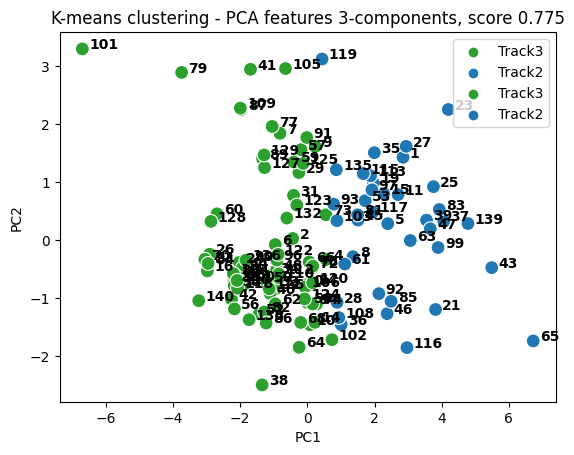

<Figure size 640x480 with 0 Axes>

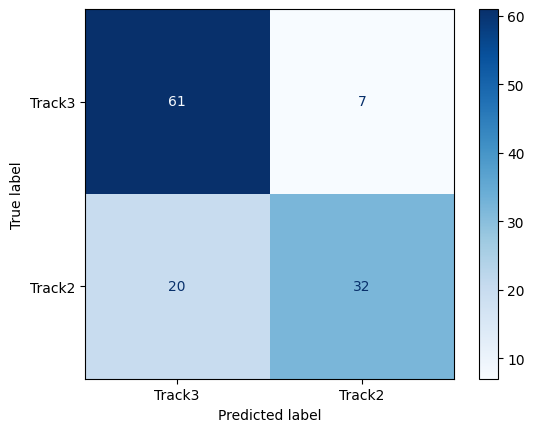

<Figure size 640x480 with 0 Axes>

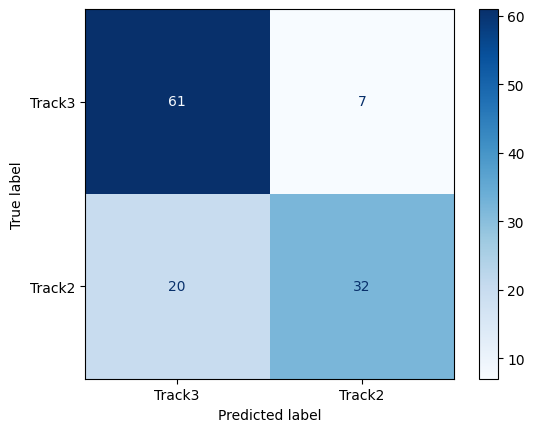

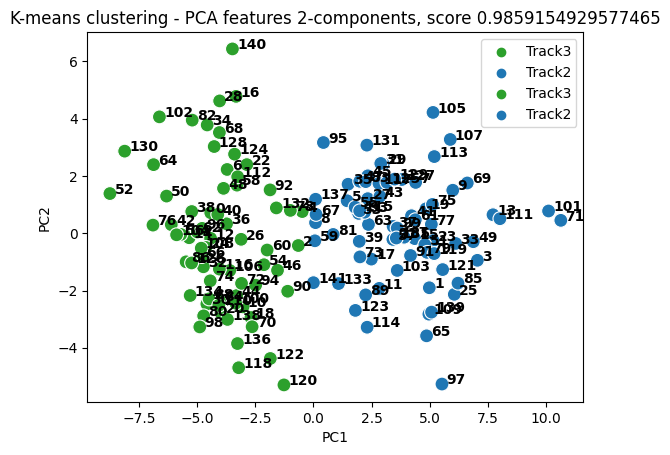

<Figure size 640x480 with 0 Axes>

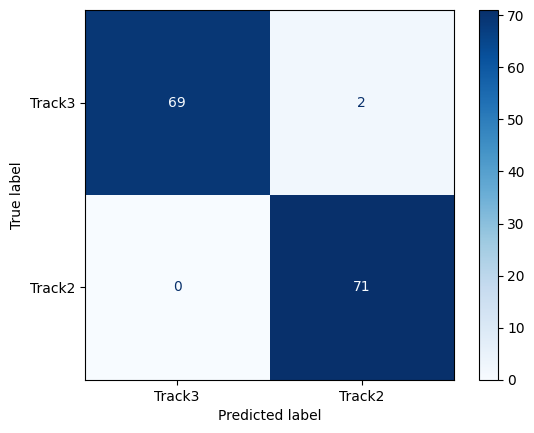

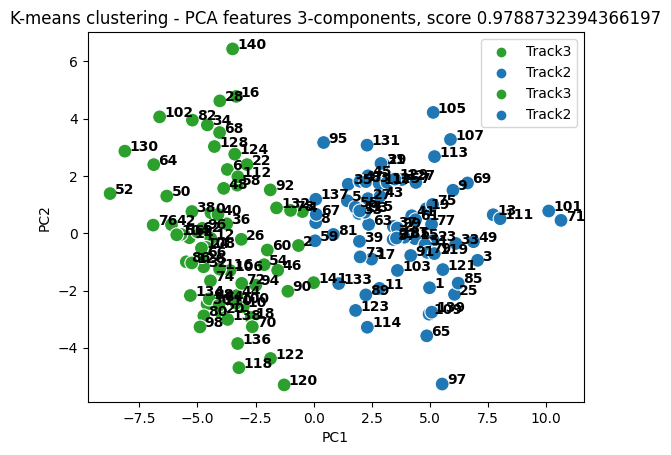

<Figure size 640x480 with 0 Axes>

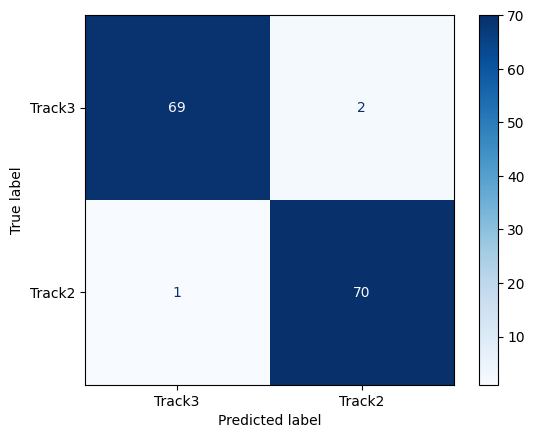

<Figure size 640x480 with 0 Axes>

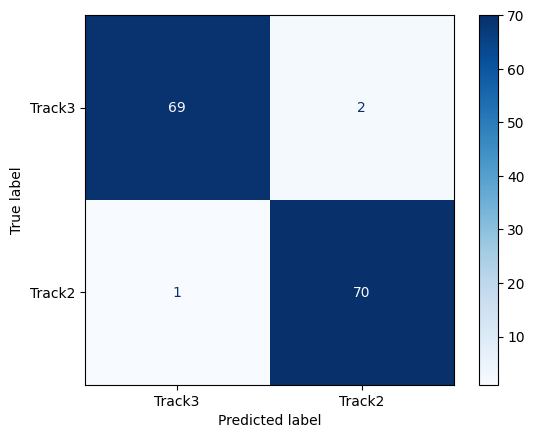

In [13]:
# set random seed to make results reproducible, changing it changes the result
random_s = 5

# number of clusters
n_cluster = len(track_names)

## clustering basic features
features_basics_tracks = features_basic\
    .join(spikes[["track"]])
cols = list(features_basics_tracks.columns)
features_basics_tracks = features_basics_tracks.dropna(axis=1)

# clustering
X = features_basics_tracks.drop(["track"], axis=1)
kmeans_pca = KMeans(n_clusters= n_cluster, init= "k-means++", n_init="auto", random_state=random_s)
predicted_label = kmeans_pca.fit_predict(X)

# encode label
le = LabelEncoder()
le = le.fit(features_basics_tracks["track"])
true_label = le.transform(features_basics_tracks["track"])
predicted_label_mapped = le.inverse_transform(predicted_label)

# plot feature space
plt.figure()
fig = sns.scatterplot(x="Amplitude", y="Width", s= 100, hue= features_basics_tracks["track"].to_list(),
               palette=track_colors,
           data=features_basics_tracks).set(title=f"Amplitude width - {dataset_name}")
plt.figure()
fig2 = sns.scatterplot(x="Amplitude", y="Width", s= 100, hue= predicted_label_mapped,
               palette=track_colors,
             data=features_basics_tracks).set(title="K-means clustering - simple features")

# evaluate results and plot confusion matrix
plt.figure()
compute_scores_clustering(true_label, predicted_label, "F1")
cm = confusion_matrix(features_basics_tracks["track"], predicted_label_mapped, labels=list(set(predicted_label_mapped)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=list(set(predicted_label_mapped)))
disp.plot(cmap=plt.cm.Blues)

## clustering PCA features 
def cluster_pca_features(df_tracks, df_no_tracks, dataset_name, color_palette,n_cluster,key, feature_name, dim= 2):
    pca = PCA(n_components=dim)
    cols = list(df_no_tracks.columns)
    # drop na and inf values
    df1 = df_no_tracks[(df_no_tracks == np.inf).any(axis=1)]
    df_no_tracks = df_no_tracks.dropna(axis=1)
    # transform to pca features
    pca_features = pca.fit_transform(df_no_tracks)
    # create df
    if dim == 2:
        pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2"])
    elif dim == 3:
        pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2" , "PC3"])
    # encode label
    le = LabelEncoder()
    le = le.fit(df_tracks["track"])
    true_label = le.transform(df_tracks["track"])
    # find id outliers, can be dropped by ID
    # using features = features.drop( [{ID}]) 
    # features_basic = features_basic.drop( [{ID}])
    plt.figure()
    fig = sns.scatterplot(x="PC1", y="PC2", s= 100, hue= df_tracks["track"].to_list(),
                   palette=color_palette,
               data=pca_df).set(title=f"Feature extraction - PCA - {dataset_name}")
    for line in range(0,pca_df.shape[0]):
        plt.text(pca_df["PC1"][line]+0.2, pca_df["PC2"][line], df_tracks.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    
    # clustering
    kmeans_pca = KMeans(n_clusters= n_cluster, init= "k-means++",n_init="auto", random_state=random_s)
    predicted_label = kmeans_pca.fit_predict(pca_df)
    predicted_label_mapped = le.inverse_transform(predicted_label)
    
    # plot first two components
    fig2 = sns.scatterplot(x="PC1", y="PC2", s= 100, hue= list(le.inverse_transform(predicted_label)),
                   palette=color_palette,
                 data=pca_df).set(title=f"K-means clustering - PCA features {dim}-components, score {accuracy_score(true_label, predicted_label)}") 
    # evaluate results and plot confusion matrix
    plt.figure()
    compute_scores_clustering(true_label, predicted_label, feature_name)
    cm = confusion_matrix(df_tracks["track"], predicted_label_mapped, labels=list(set(predicted_label_mapped)))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=list(set(predicted_label_mapped)))
    disp.plot(cmap=plt.cm.Blues)
    

## clustering PCA of SS-SPDF features
features_tracks = features\
    .join(spikes[["track"]])
cols = list(features_tracks.columns)
features_tracks = features_tracks.dropna(axis=1)
X = features_tracks.drop(["track"], axis=1)
cluster_pca_features(features_tracks, X, dataset_name, track_colors, n_cluster, key ="pca complex features", feature_name="F2")
cluster_pca_features(features_tracks, X, dataset_name, track_colors, n_cluster, key= "pca complex features", feature_name="F3", dim=3)


## clustering raw SS-SPDF features
plt.figure()
kmeans_pca = KMeans(n_clusters= n_cluster, init= "k-means++",n_init="auto", random_state=random_s)
predicted_label = kmeans_pca.fit_predict(X)

# encode label
le = LabelEncoder()
le = le.fit(features_tracks["track"])
true_label = le.transform(features_tracks["track"])
predicted_label_mapped = le.inverse_transform(predicted_label)

# evaluate results and plot confusion matrix
compute_scores_clustering(true_label, predicted_label, "F4")
cm = confusion_matrix(features_tracks["track"], predicted_label_mapped, labels=list(set(predicted_label_mapped)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=list(set(predicted_label_mapped)))
disp.plot(cmap=plt.cm.Blues)

## clustering PCA of raw signal
spikes_raw = ap_derivatives\
    .join(spikes[["track"]])
X = pd.DataFrame(spikes_raw["raw"].to_list(), columns=np.arange(0,len(spikes_raw["raw"].iloc[0])))
cluster_pca_features(spikes_raw, X, dataset_name, track_colors, n_cluster, key= "PCA of raw signal", feature_name="F5")
cluster_pca_features(spikes_raw, X, dataset_name, track_colors, n_cluster, key= "PCA of raw signal", feature_name="F6", dim=3)

## clustering raw signal
kmeans_pca = KMeans(n_clusters= n_cluster,n_init="auto", init= "k-means++", random_state=random_s)
predicted_label = kmeans_pca.fit_predict(X)

# encode label
le = LabelEncoder()
le = le.fit(spikes_raw["track"])
true_label = le.transform(spikes_raw["track"])
predicted_label_mapped = le.inverse_transform(predicted_label)

# evaluate results and plot confusion matrix
compute_scores_clustering(true_label, predicted_label, "F7")
plt.figure()
cm = confusion_matrix(spikes_raw["track"], predicted_label_mapped, labels=list(set(predicted_label_mapped)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=list(set(predicted_label_mapped)))
disp.plot(cmap=plt.cm.Blues)

# print all results
for key in clustering_scores_dict:
    print(key, clustering_scores_dict[key])
    

### Classification

For classification, we use Support Vector Machine (SVM) clustering with a radial basis function (RBF) kernel. To ensure the model's generalizability, we apply 5-fold cross-validation. We then average the scores from each fold to evaluate the overall performance of the classifier.

C:\Users\alina\AppData\Local\Temp\ipykernel_26872\574644505.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,track
0,0.640594,-0.039483,-0.628139,-1.206272,-1.622279,-1.356889,-0.693910,-0.588676,-0.660696,0.172630,...,3.589772,3.778864,3.541759,3.057685,2.683119,1.760021,0.277864,-1.349326,-2.445415,Track3
1,-0.152610,-0.671877,-0.669246,-0.588347,-0.528495,-0.362092,-0.127946,0.023658,-0.060530,-0.236140,...,0.918478,1.801457,1.921161,1.673203,1.142100,0.393622,-0.104268,-0.093087,0.218341,Track2
2,0.119026,0.354159,0.533058,1.120067,1.271999,0.916834,0.699788,-0.097362,-1.287829,-1.777500,...,3.722630,3.915338,3.376674,2.442397,1.412749,0.411709,-0.449240,-1.281252,-1.838010,Track3
3,-1.075057,-0.073026,0.876055,1.487728,1.389071,0.877371,0.512668,0.166053,-0.739293,-1.146091,...,0.582057,1.064490,1.601513,1.488715,1.402555,0.984907,0.268985,-0.315723,-0.502515,Track2
4,-0.182865,-0.200294,-0.187469,0.168684,0.578769,0.987538,0.956625,0.120342,-1.125702,-1.090514,...,3.070182,3.121812,2.706797,2.268103,1.769229,0.462025,-0.491005,-0.662669,-0.611367,Track3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,-0.417341,-0.096046,0.287072,0.371260,0.057530,-0.422273,-0.523891,-0.775138,-0.695555,0.520561,...,2.198057,2.114199,1.747196,1.534426,1.767256,2.054018,1.700498,0.835935,0.273918,Track2
138,0.386387,-0.070067,-0.283167,0.013134,0.241361,0.250898,0.263724,-0.000349,-0.855051,-1.331896,...,4.745038,4.649341,3.363191,2.069475,1.176630,0.745499,0.448870,0.215382,-0.502844,Track3
139,-0.311119,0.603104,1.450897,1.718256,1.639002,1.293703,0.804693,-0.065463,-1.364782,-1.415755,...,1.099020,1.171369,1.702800,1.825135,1.269697,1.210174,1.054625,0.939525,0.620205,Track2
140,0.782002,0.370273,-0.185167,-0.789608,-1.078675,-1.017507,-1.355903,-1.768292,-1.907071,-0.204898,...,4.085356,2.508826,1.257200,0.082523,-0.622548,-0.768232,-0.503501,-0.753762,-1.016520,Track3


F1 {'Accuracy': 0.9917, 'Precision': 0.9909, 'Recall': 0.9929, 'F1-score': 0.9915}
F2 {'Accuracy': 0.4333, 'Precision': 0.4279, 'Recall': 0.4333, 'F1-score': 0.426}
F3 {'Accuracy': 0.4583, 'Precision': 0.4582, 'Recall': 0.4583, 'F1-score': 0.4549}
F4 {'Accuracy': 0.9, 'Precision': 0.9279, 'Recall': 0.8855, 'F1-score': 0.8927}
F5 {'Accuracy': 0.9579, 'Precision': 0.9614, 'Recall': 0.9586, 'F1-score': 0.9578}
F6 {'Accuracy': 0.9579, 'Precision': 0.9614, 'Recall': 0.9586, 'F1-score': 0.9578}
F7 {'Accuracy': 0.9929, 'Precision': 0.9933, 'Recall': 0.9929, 'F1-score': 0.9928}


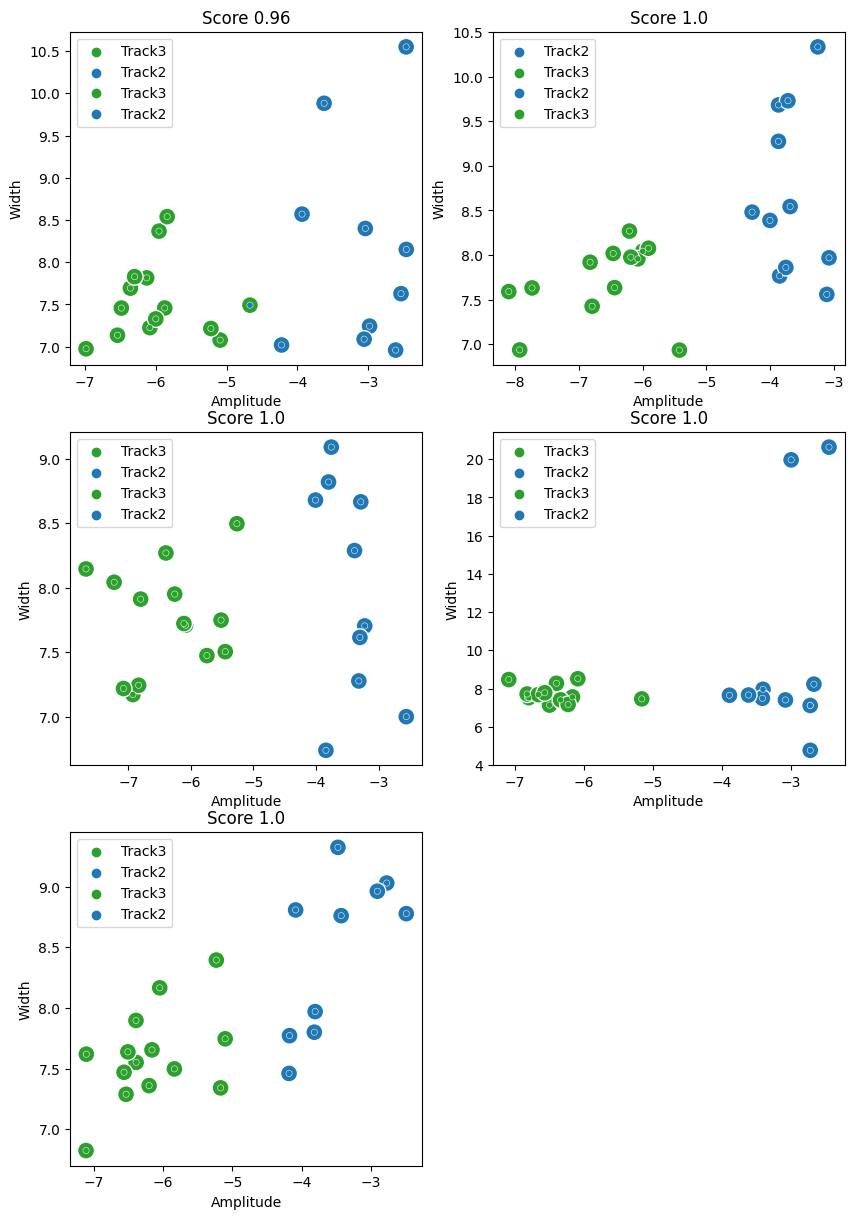

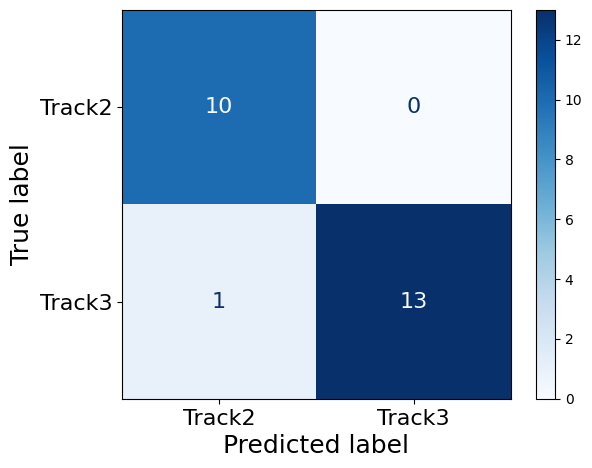

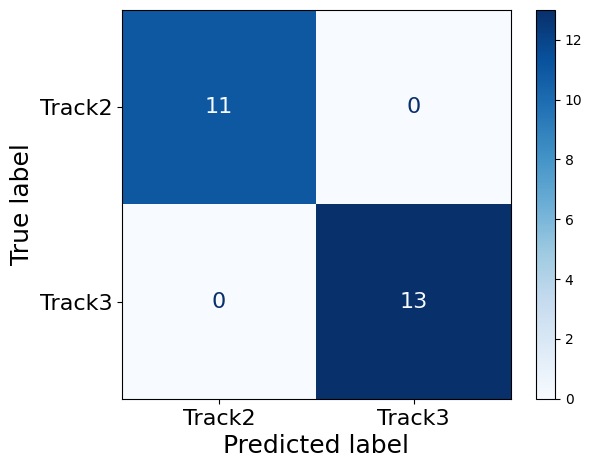

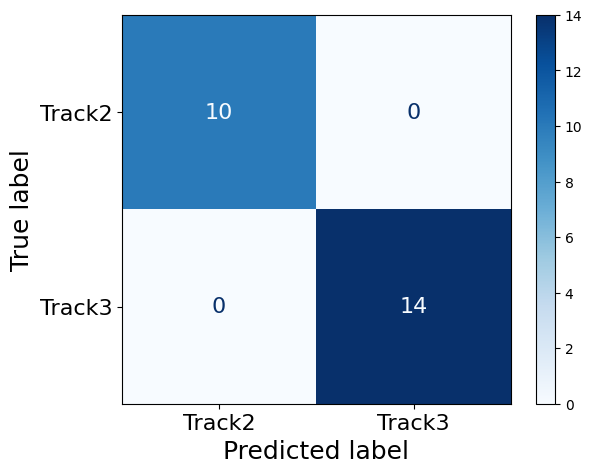

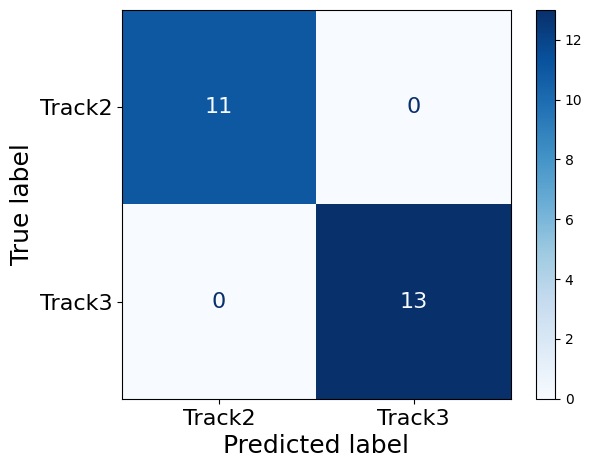

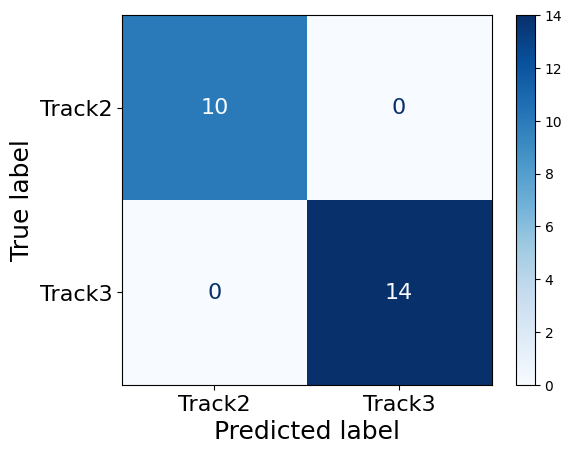

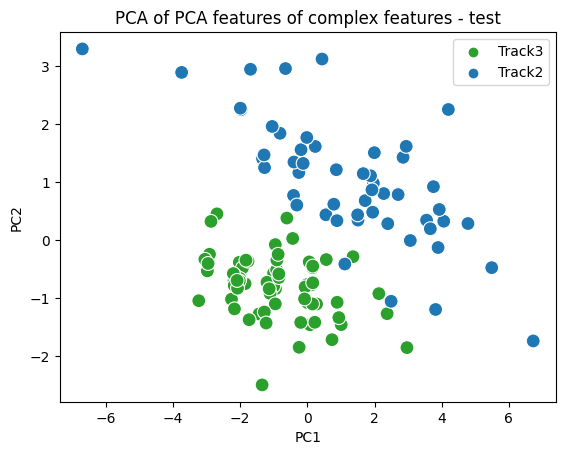

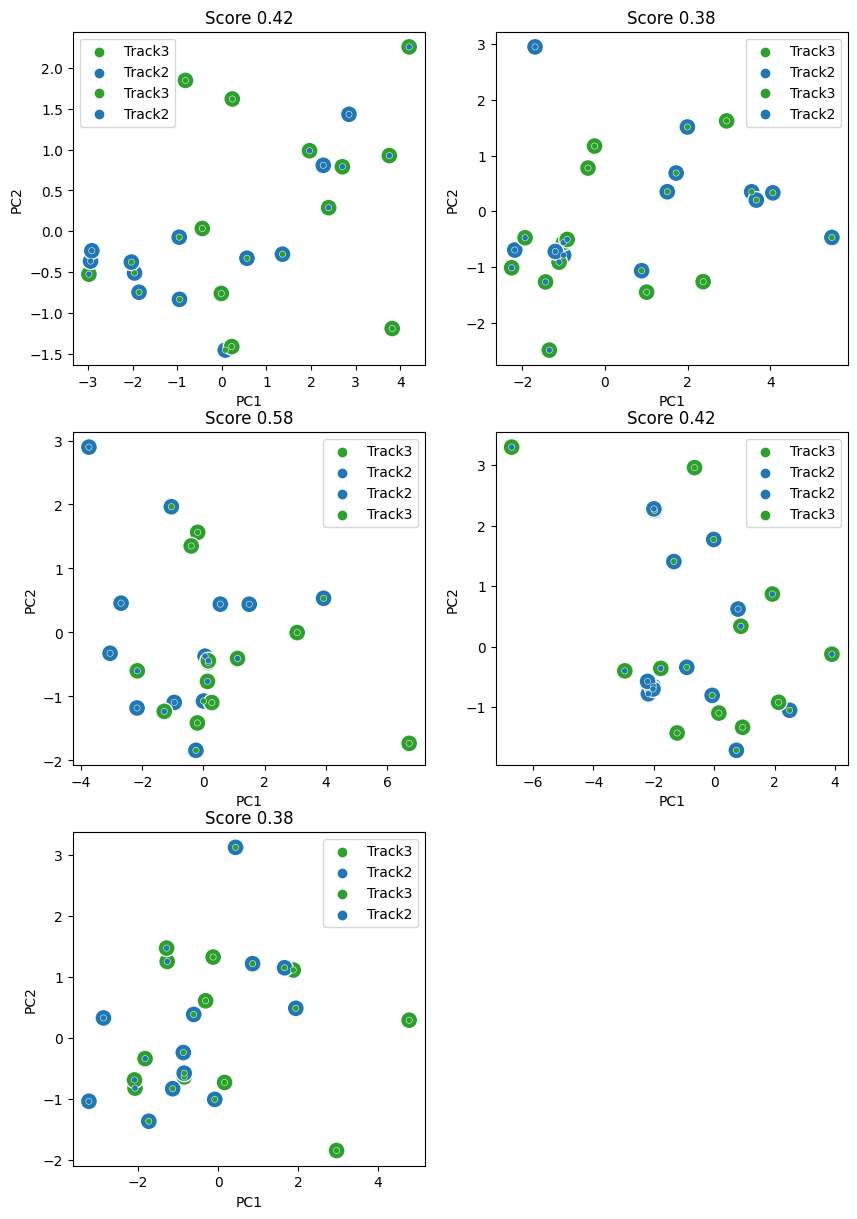

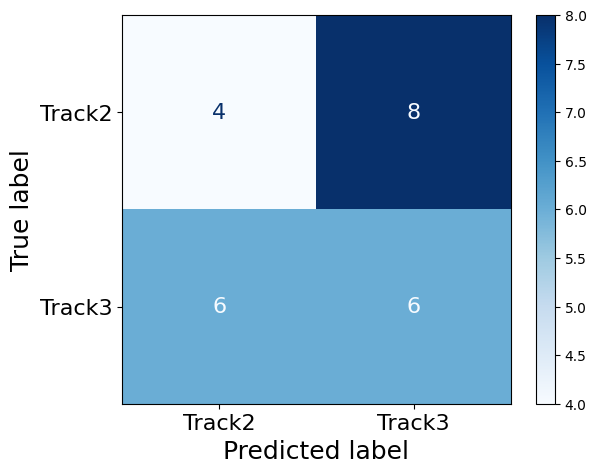

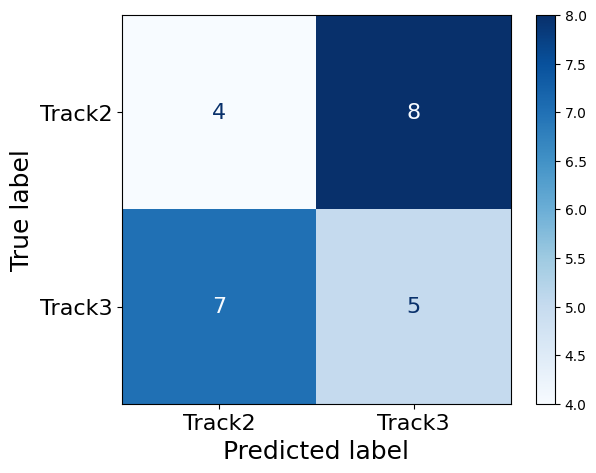

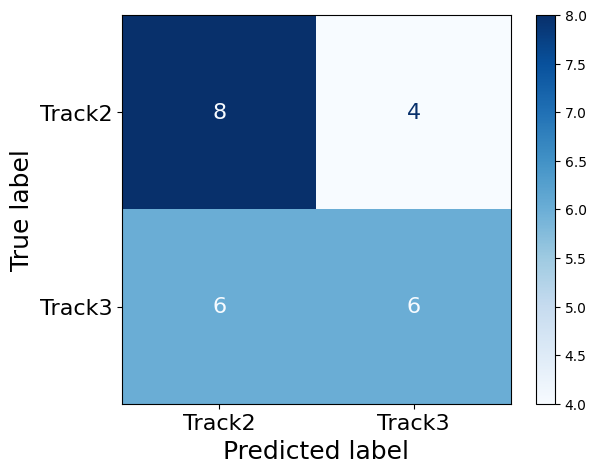

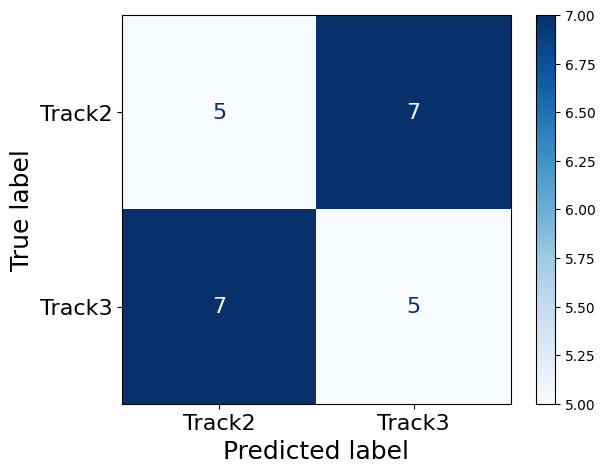

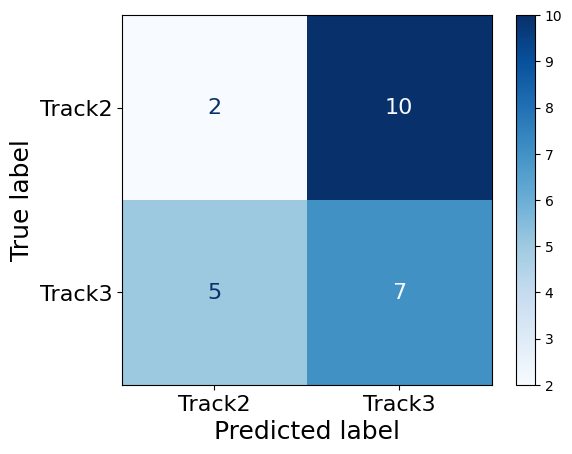

<Figure size 640x480 with 0 Axes>

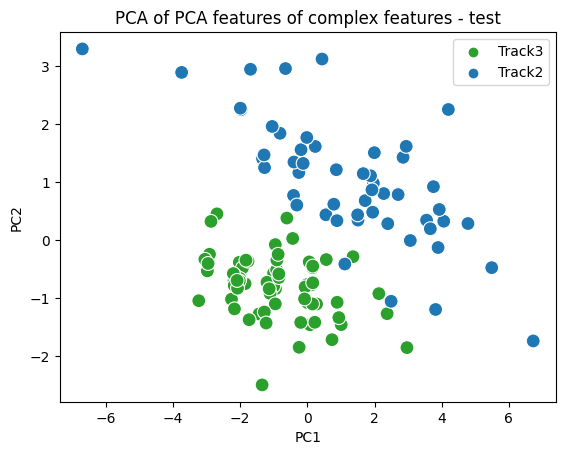

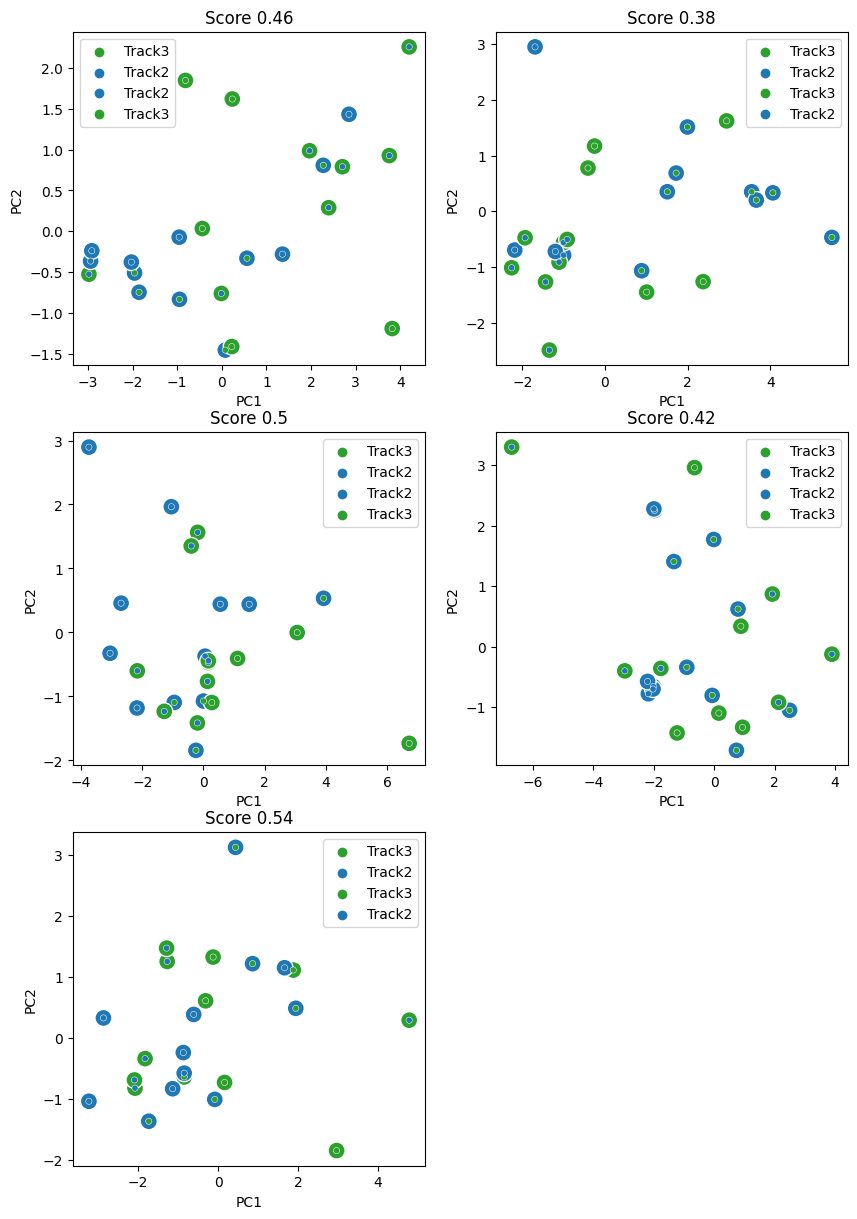

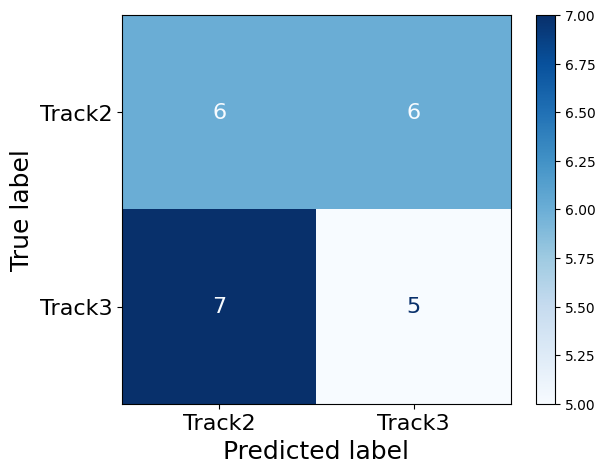

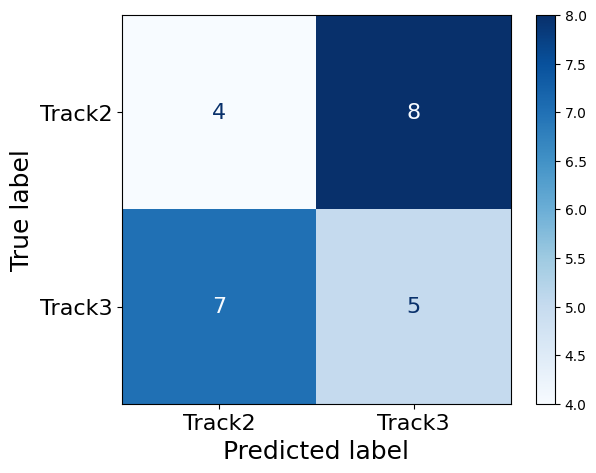

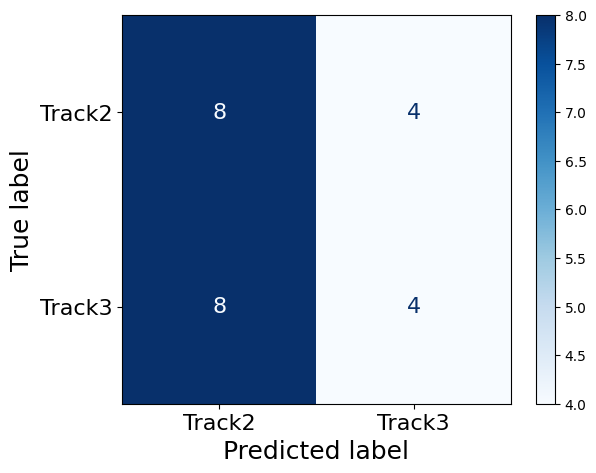

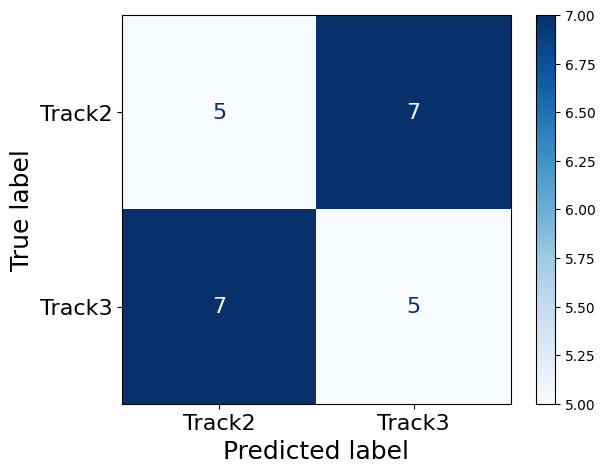

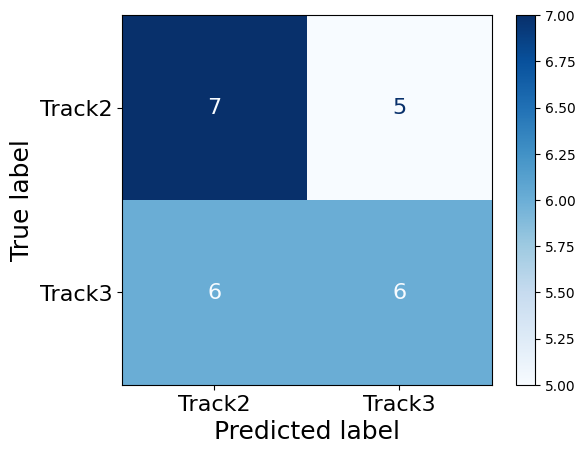

<Figure size 640x480 with 0 Axes>

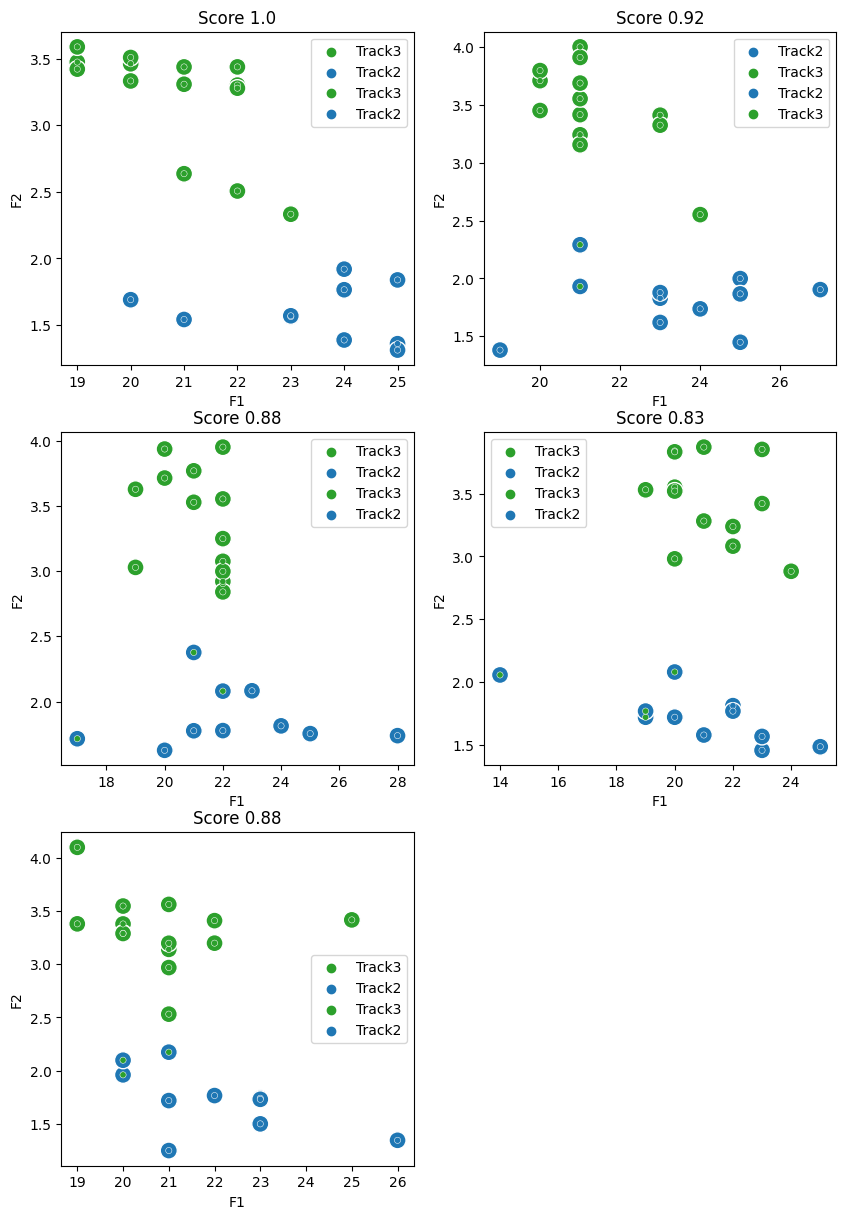

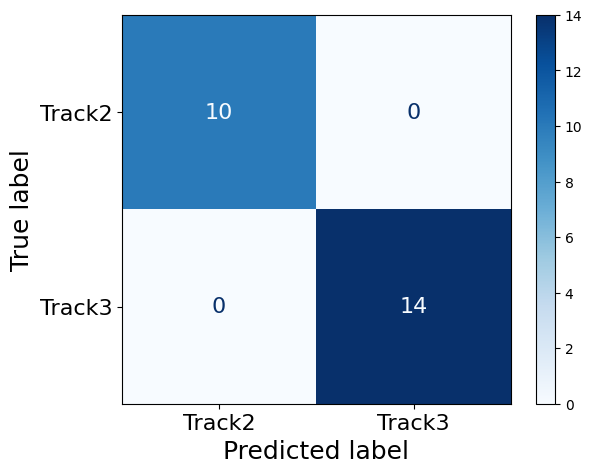

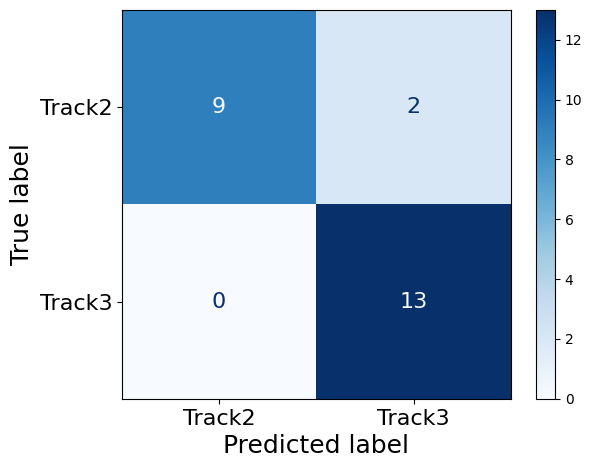

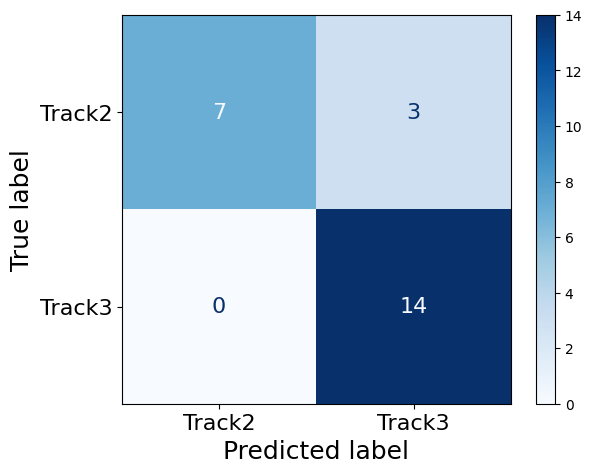

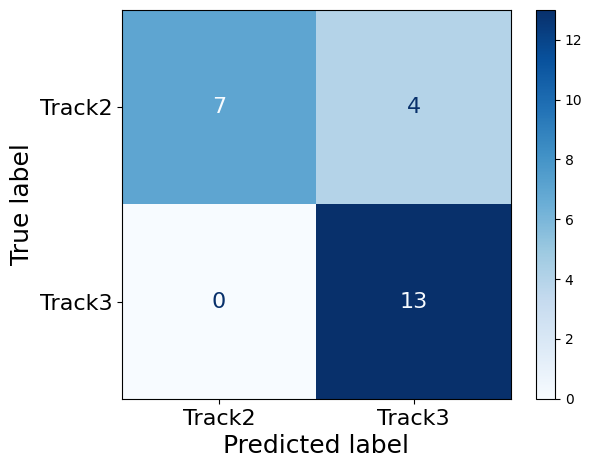

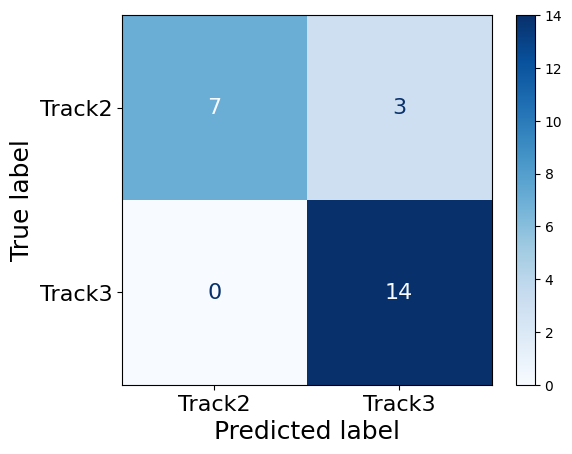

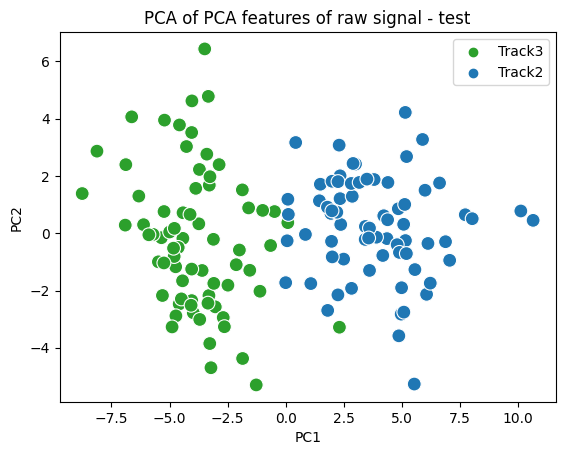

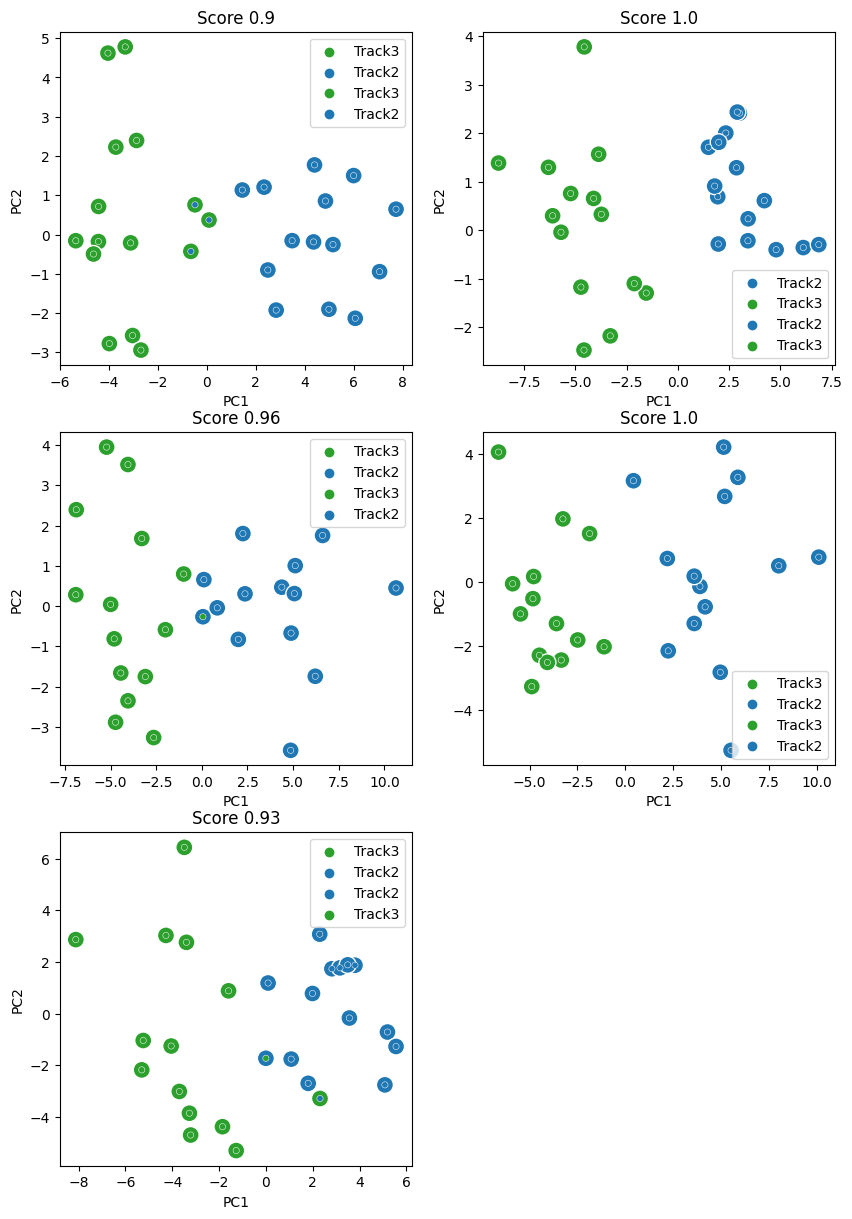

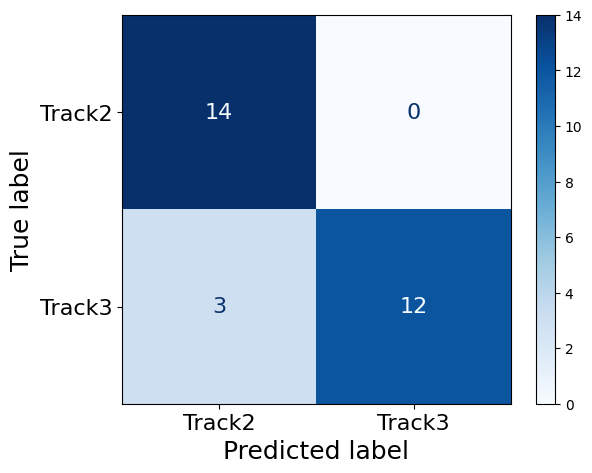

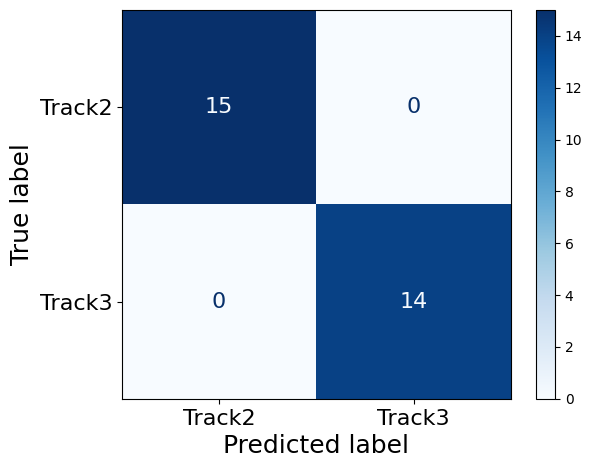

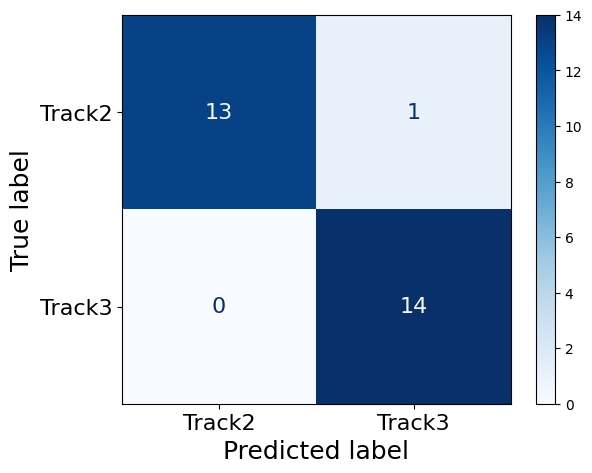

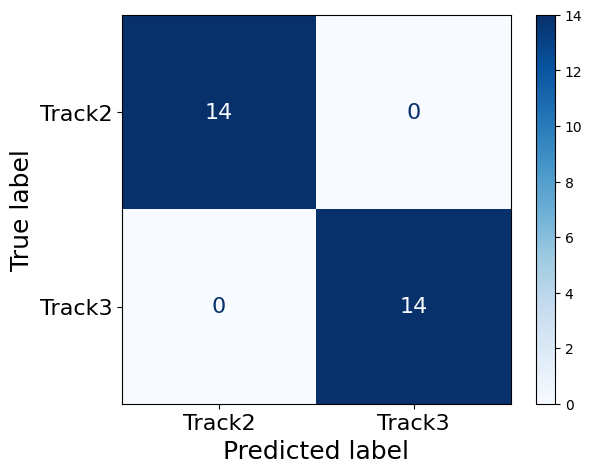

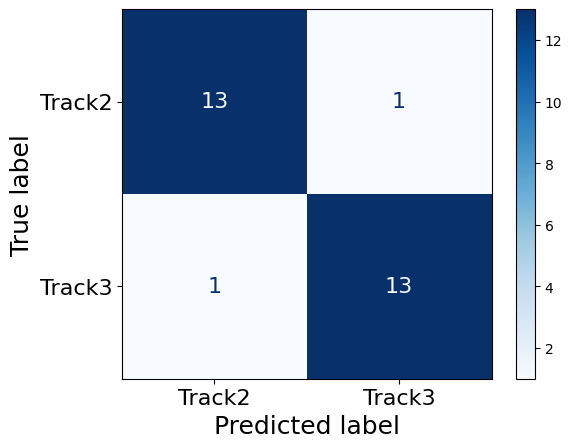

<Figure size 640x480 with 0 Axes>

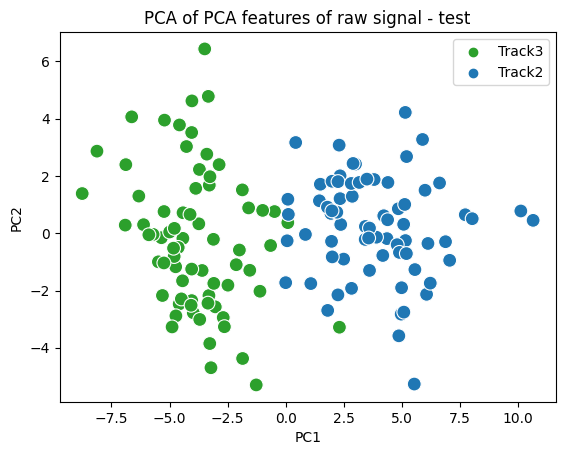

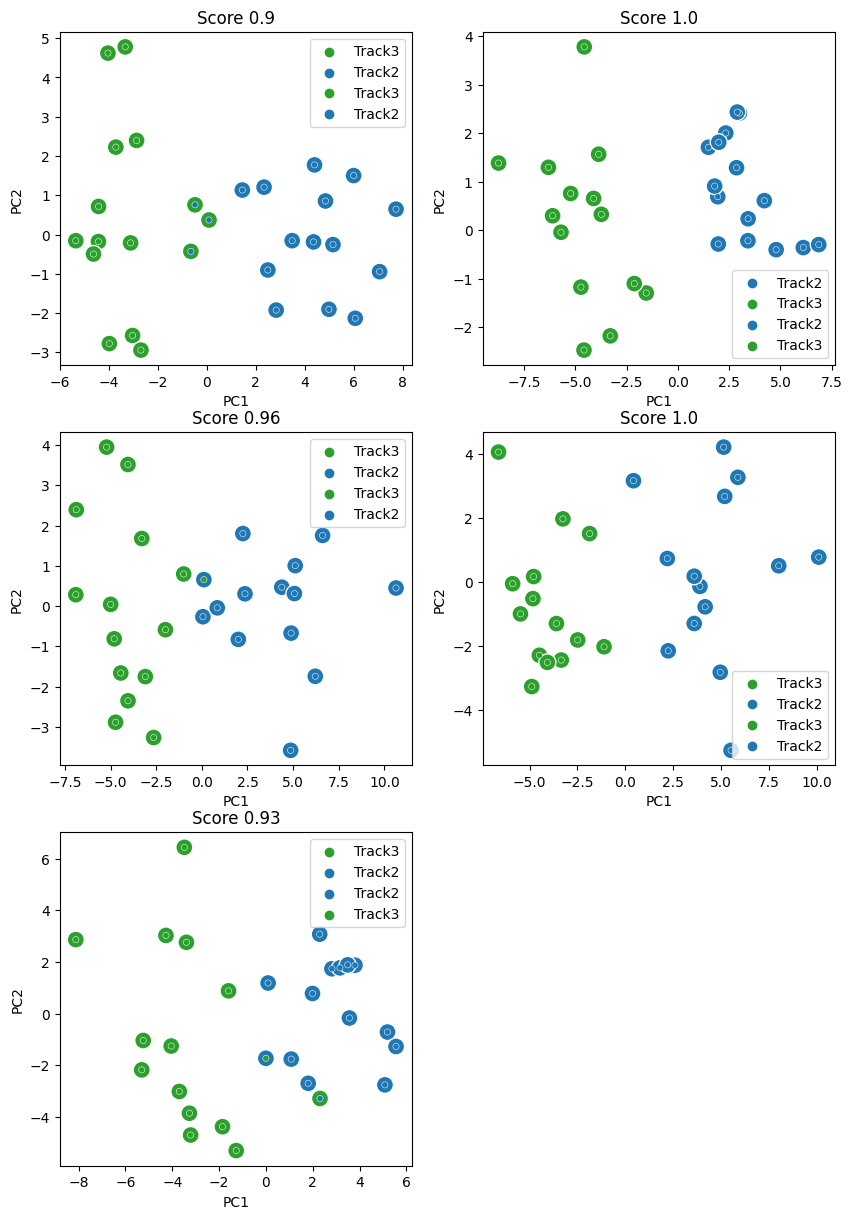

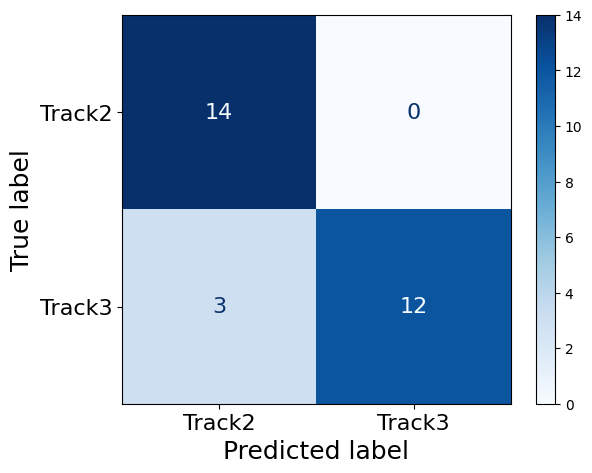

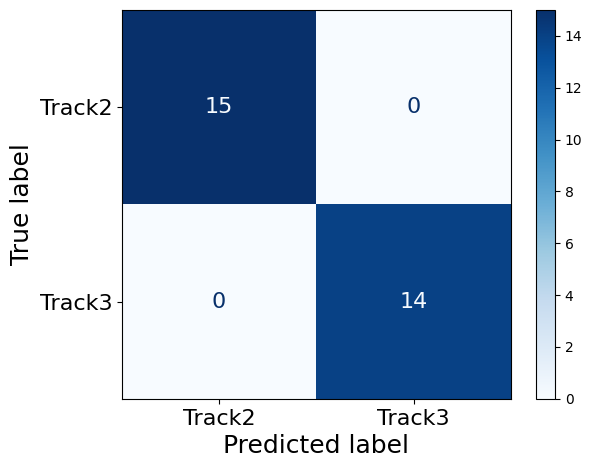

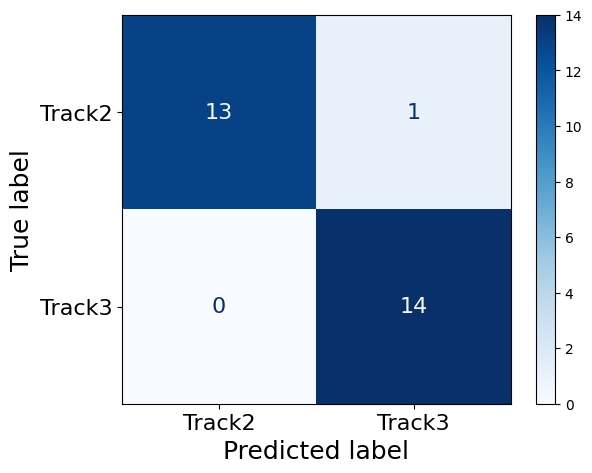

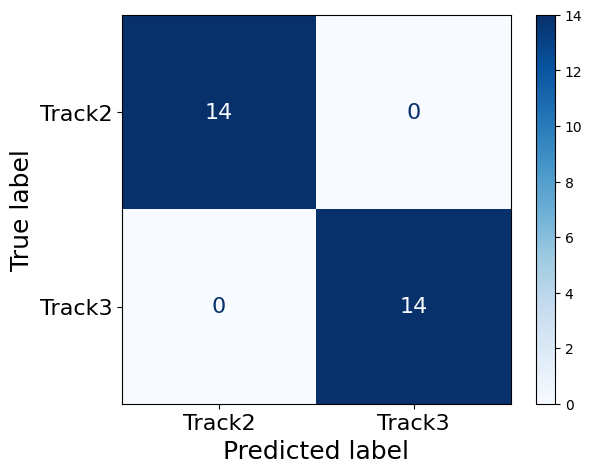

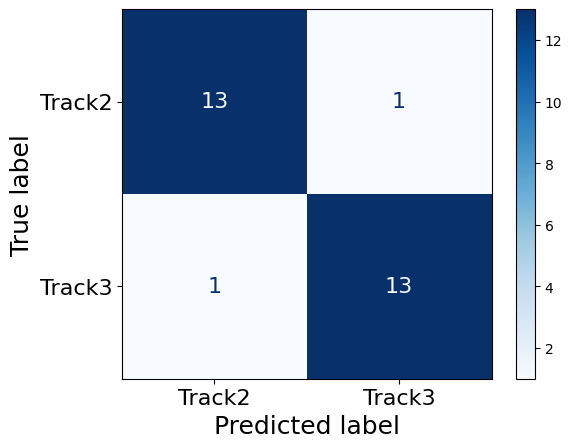

<Figure size 640x480 with 0 Axes>

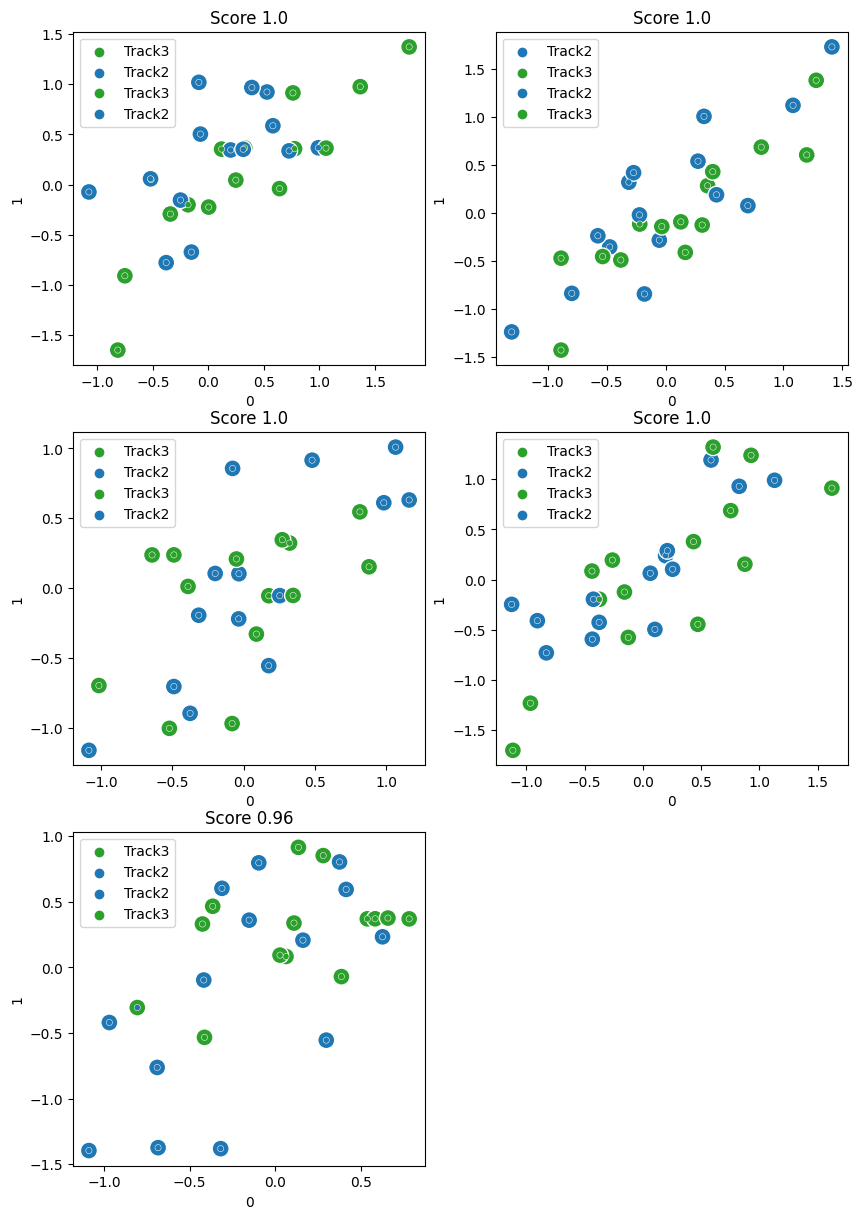

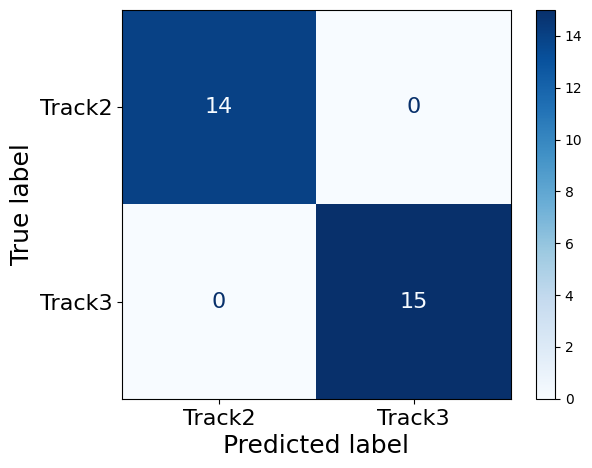

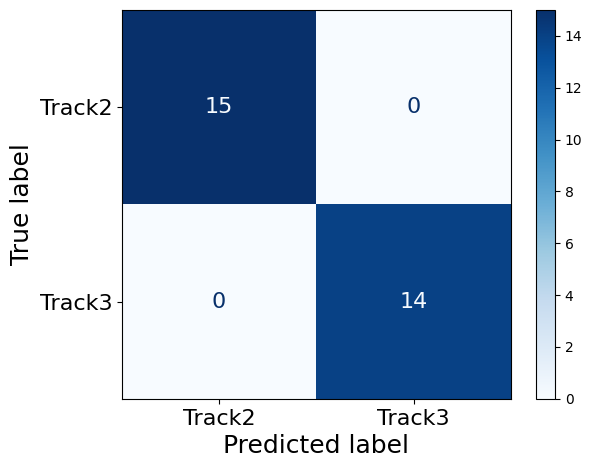

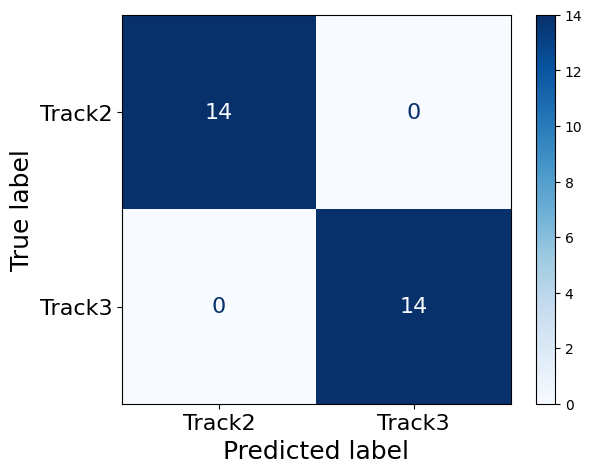

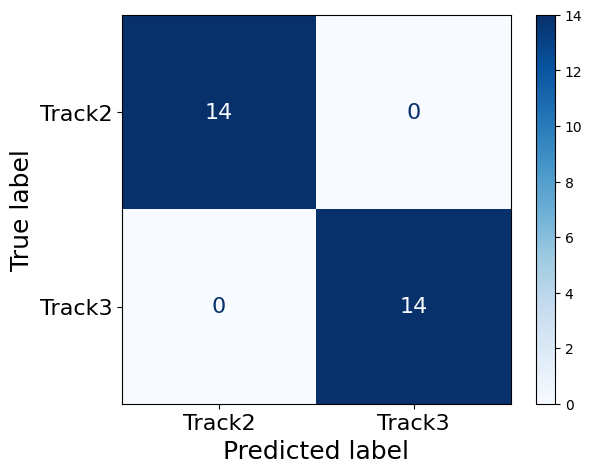

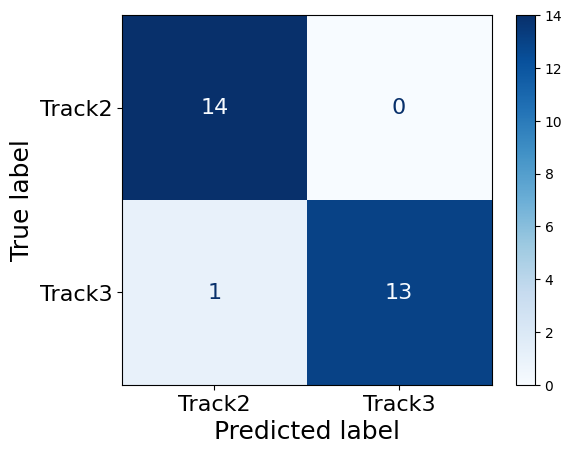

In [14]:
# mapping dict for subplots
map_sub = {0:(0,0), 1:(0,1), 2:(1,0), 3:(1,1), 4:(2,0), 5:(2,1)}


# classification method 
def classification(features, key, feature_name):
    fig, axs = plt.subplots(3,2, figsize=(10,14))
    # remove NAs and prepare data
    features = features.dropna(axis=1)
    X = features.drop(["track"], axis=1)
    data_label = features["track"]
    # use 5-fold cross validation and collect the scores in lists
    scores = []
    kf = KFold(n_splits=5, random_state=None, shuffle=False)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        # split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = data_label.iloc[train_index], data_label.iloc[test_index]
        # train classifier and predict
        clf = svm.SVC(kernel='rbf') 
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        # plot results for each fold
        axs[map_sub[i][0], map_sub[i][1]].set_title(f"Fold: {i}, Accuracy: {round(accuracy_score(np.array(y_test), y_pred), 2)}" )
        axs[2,1].axis('off')
        sns.scatterplot(x=features.columns[0], y=features.columns[1], s= 150, hue= np.array(y_test),
               palette=track_colors, ax= axs[map_sub[i][0], map_sub[i][1]],
             data=X_test).set(title=f"Score {round(accuracy_score(y_test, y_pred),2)}")
        sns.scatterplot(x=features.columns[0], y=features.columns[1], s= 20, hue= y_pred, ax= axs[map_sub[i][0], map_sub[i][1]],
               palette=track_colors,
             data=X_test)
        fig.subplots_adjust(top=0.92)
        # evaluate and plot results
        fig, ax = plt.subplots()
        compute_scores_classification(y_test, y_pred, feature_name)
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        for labels in disp.text_.ravel():
            labels.set_fontsize(16)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_xlabel("Predicted label", fontsize=18)
        ax.set_ylabel("True label", fontsize=18)
    return scores

# classification for PCA features
def classification_PCA(df_features, df_features_notracks, color_palette, dataset_name, key, feature_name, dim= 2):
    pca = PCA(n_components=dim)
    df_features_notracks = df_features_notracks.dropna(axis=1)
    df_features = df_features.dropna(axis=1)
    pca_features = pca.fit_transform(df_features_notracks)
    if dim == 2:
        pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2"])
    elif dim == 3:
        pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2" , "PC3"])
    plt.figure()
    fig = sns.scatterplot(x="PC1", y="PC2", s= 100, hue= df_features["track"].to_list(),
                   palette=color_palette,
               data=pca_df).set(title=f"PCA of {key} - {dataset_name}")
    pca_df = pca_df.join( spikes[["track"]])
    pca_df = pca_df[pca_df['track'].notna()]
    scores = classification(pca_df, key, feature_name)
    plt.figure()
    
## classification basic features
features_tracks_basic= features_basic\
    .join(spikes[["track"]])
key = "simple features"
scores = classification(features_tracks_basic, key, "F1")

    
## classification PCA of complex features
features_tracks = features\
    .join(spikes[["track"]])
features_no_tracks = features_tracks.drop(["track"], axis=1)
classification_PCA(features_tracks, features_no_tracks, track_colors, dataset_name, key="PCA features of complex features", feature_name="F2")
classification_PCA(features_tracks, features_no_tracks, track_colors, dataset_name, key="PCA features of complex features", feature_name="F3", dim=3)


# classification raw complex features
df_features = features\
    .join(spikes[["track"]])
key = "raw complex features"
scores = classification(df_features, key, "F4")

## classification PCA raw waveform    
spikes_raw = ap_derivatives\
    .join(spikes[["track"]])


## classification PCA of raw waveform features
X = pd.DataFrame(spikes_raw["raw"].to_list(), columns=np.arange(0,len(spikes_raw["raw"].iloc[0]))) 
classification_PCA(spikes_raw, X, track_colors, dataset_name, key="PCA features of raw signal", feature_name="F5")
classification_PCA(spikes_raw, X, track_colors, dataset_name, key="PCA features of raw signal",feature_name= "F6", dim=3)


## classification raw waveform
spikes_raw = X.join(spikes[["track"]])
key = "raw waveform features"
display(spikes_raw)
scores = classification(spikes_raw, key, "F7")

# compute mean for classification scores (average scores from each fold)
compute_mean_classificaton()

# print all results
for key in classification_score_mean_dicts:
    print(key, classification_score_mean_dicts[key])

## Results

Collect and print all results in dataframes.

In [19]:
clustering_results = pd.DataFrame.from_dict(clustering_scores_dict)
classification_results = pd.DataFrame.from_dict(classification_score_mean_dicts)
display(clustering_results)
display(classification_results)

,F1,F2,F3,F4,F5,F6,F7
V-measure,1.0000,0.2204,0.2343,0.2343,0.9071,0.8540,0.8540
Rand index,1.0000,0.6392,0.6483,0.6483,0.9720,0.9583,0.9583
ARI,1.0000,0.2776,0.2959,0.2959,0.9441,0.9167,0.9167
MI,0.6842,0.1442,0.1540,0.1540,0.6286,0.5919,0.5919
NMI,1.0000,0.2204,0.2343,0.2343,0.9071,0.8540,0.8540
AMI,1.0000,0.2153,0.2293,0.2293,0.9066,0.8532,0.8532
Homogeneity,1.0000,0.2107,0.2251,0.2251,0.9069,0.8539,0.8539
FMI,1.0000,0.6633,0.6698,0.6698,0.9718,0.9581,0.9581
Completeness,1.0000,0.2309,0.2442,0.2442,0.9074,0.8540,0.8540
Accuracy,1.0000,0.2333,0.7750,0.7750,0.9859,0.9789,0.9789


,F1,F2,F3,F4,F5,F6,F7
Accuracy,0.9917,0.4333,0.4583,0.9000,0.9579,0.9579,0.9929
Precision,0.9909,0.4279,0.4582,0.9279,0.9614,0.9614,0.9933
Recall,0.9929,0.4333,0.4583,0.8855,0.9586,0.9586,0.9929
F1-score,0.9915,0.4260,0.4549,0.8927,0.9578,0.9578,0.9928
